# Visualyzing Inner Encoder Inner layers Experiment

### Summary:

0. Train model on data
1. test model on data and obtain hidden features.
2. project data on 2d using PCA or UMAP
3. Drafts with plots of 2d projections.


### OBS. To start with, try only on the test dataframe

category_names = ['building', ' water', 'tree', 'sky']#[' building' ' water' ' road ' ' sidewalk' ' surface' ' tree' ' sky'] 'miscellaneous'



# Overall / Global Data generation steps:

See Chapter 1, below for obtaining the testing predictions 

!!! Step 2 - the physical splits between training and testing locations are not in this notebook, but in:

`./NeRF_vs_Vanilla_Physical_Splits_Interpolator_experiment.ipynb`

1. Download from the semnatic interface - csv format: x,y,z,xh,yh,zh,f_xyz,image_name
2. Perform physical splits between as train and test separate locations : Check `./NeRF_vs_Vanilla_Physical_Splits_Interpolator_experiment.ipynb`
3. Train model on train locations and Compute Predctions on the separate test physical locations.
4. Compute zip assignment for each location base on the knn `locations_to_zip(xyz_locations)` method in `gradient_walk_utils.py`

In [25]:
test_df.y.sort_values()

test_df[test_df.y < 100].shape, test_df.shape

# test_df[test_df.y < 50]

((4320, 22), (15000, 22))

In [9]:
test_df.groupby("zip").count()

x     y     z    xh    yh    zh  f_xyz  image_name    xn    yn  ...  \
zip                                                                       ...   
10021   858   858   858   858   858   858    858         858   858   858  ...   
10024  2568  2568  2568  2568  2568  2568   2568        2568  2568  2568  ...   
10025   474   474   474   474   474   474    474         474   474   474  ...   
10028  3144  3144  3144  3144  3144  3144   3144        3144  3144  3144  ...   
10029  1590  1590  1590  1590  1590  1590   1590        1590  1590  1590  ...   
10044   264   264   264   264   264   264    264         264   264   264  ...   
10075  1110  1110  1110  1110  1110  1110   1110        1110  1110  1110  ...   
10128  3990  3990  3990  3990  3990  3990   3990        3990  3990  3990  ...   
11102  1002  1002  1002  1002  1002  1002   1002        1002  1002  1002  ...   

        xhn   yhn   zhn  f_xyz_raw  residual  steps  start_locs  start_views  \
zip                                                                            
10021   858   858   858        858       858    858         858          858   
10024  2568  2568  2568       2568      2568   2568        2568         2568   
10025   474   474   474        474       474    474         474          474   
10028  3144  3144  3144       3144      3144   3144        3144         3144   
10029  1590  1590  1590       1590      1590   1590        1590         1590   
10044   264   264   264        264       264    264         264          264   
10075  1110  1110  1110       1110      1110   1110        1110         1110   
10128  3990  3990  3990       3990      3990   3990        3990         3990   
11102  1002  1002  1002       1002      1002   1002        1002         1002   

        PCA  UMAP  
zip                
10021   858   858  
10024  2568  2568  
10025   474   474  
10028  3144  3144  
10029  1590  1590  
10044   264   264  
10075  1110  1110  
10128  3990  3990  
11102  1002  1002  

[9 rows x 21 columns]

In [13]:
#Colors to be used as zip encodings in the heatmap plot
import pandas as pd

test_df_json_path = "./utils/assets/data/semantics_final/test_set_as_query.json"

test_df = pd.read_json(test_df_json_path)

zip_codes = test_df.groupby("zip").count().index.values

zip_colors = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69','#fccde5','#d9d9d9']#https://colorbrewer2.org/#type=qualitative&scheme=Set3&n=9

zip_dictionary = {z:c for z,c in zip(zip_codes, zip_colors)}

zip_dictionary

{10021: '#8dd3c7',
 10024: '#ffffb3',
 10025: '#bebada',
 10028: '#fb8072',
 10029: '#80b1d3',
 10044: '#fdb462',
 10075: '#b3de69',
 10128: '#fccde5',
 11102: '#d9d9d9'}

# Selection of small Querry based on different:

1. zip codes;
2. semantics;
3. 2D Projections;

In [16]:

test_df_json_path.replace("test_set_as_query", "small_query")



'./utils/assets/data/semantics_final/small_query.json'

In [14]:
import numpy as np


#1. Zip codes small query:
np.random.seed(1)

zip_codes_small_query_dfs = []

for zipcode in zip_codes:
    zipcode_df = test_df[test_df["zip"] == zipcode]
    
    # 1 if less then 1k --- 3 if between 1k and 2k --- 5 if above 2k
    num_locations_per_zip = 1 if zipcode_df.shape[0] < 1000 \
                                else (3 if zipcode_df.shape[0] < 2000 else 5)
    
    # print(num_locations_per_zip)
        
    zip_codes_small_query_dfs.append(zipcode_df.sample(num_locations_per_zip))
                 

small_query_df = pd.concat(zip_codes_small_query_dfs)


small_query_json_path = test_df_json_path.replace("test_set_as_query", "small_query")


small_query_df.to_json(small_query_json_path, indent=4, orient="records")

print(f"Small query saved at: \n\t{small_query_json_path}")

        
#2. Semantics based small query:
# np.random.seed(1)
                  
#3. 2D projections based small query
# np.random.seed(1)

Small query saved at: 
	./utils/assets/data/semantics_final/small_query.json


# 0. Train encoder on full semantics

See below for loading the trained model and computing hidden featutes.

In [2]:
from utils.scripts.architectures.train_location_encoder import train_model_on_data


# Semantics paths
# file_store = "./utils/assets/data/full_semantics/train_set_100-percent.csv"
# selected_label_indexes = [0,1,2,3,4,5,6,7]#['building', 'water', 'road ', 'sidewalk', 'surface', 'tree', 'sky', 'miscellaneous']
# ne = 1000 #semantics

# Perception paths
# file_store = "./utils/assets/data/perception_metrics/train_set_100-percent.csv"
# selected_label_indexes = [0,1,2,3,4,5]#['greenness' 'openness' 'imageability' 'enclosure' 'walkability' 'serenity']
# ne = 350 #perception 

# Final Semantics paths
# file_store = "./utils/assets/data/semantics_final/train_set_100-percent.csv"
# selected_label_indexes = [0,1,2,3,4,5,6,7] #['building', 'water', 'road ', 'sidewalk', 'surface', 'tree', 'sky', 'miscellaneous']
# ne = 1000 #final semantics

# Buildings Outlier Semantics paths
file_store = "./utils/assets/data/buildings_outlier/train_set_100-percent.csv"
selected_label_indexes = [0,1]#[0,1,2,3,4,5] #['brick','concrete','marble' ,'plaster','metal','nothing']
ne = 1000 #final semantics

# Train NeRF for ne epochs
model_name = f"encoder_{ne}.pt"
encoder_net, tr_losses_history, test_losses_history, vdf \
    = train_model_on_data(data_path=file_store, num_epochs=ne, model_name=model_name\
                          , selected_label_indexes=selected_label_indexes)


Normalizing each label value by: 450,241

Normalized f_xyz between -1 ([-1. -1.]) and 1 ([1.        0.3970518]), considering the maximum label row value of 450241
Train model based on selected label indexes: ['brick' 'concrete']
Training data percentace 100.00% - 16,713 samples, for 1000 epochs:


Epoch 1000 / 1000- Training loss 0.10654 - test loss 0.17106: 100%|█████████████████████████████████████████████████████████████████████████████████| 1000/1000 [40:54<00:00,  2.45s/it]

{'classes_names': ['brick', 'concrete', 'marble', 'plaster', 'metal', 'nothing']}
Model weights saved at:
	./utils/assets/data/buildings_outlier/models/encoder_1000.pt

Training for 
	1000     epochs took: 
	2,454s, for an average of: 
	2.5s per epoch.


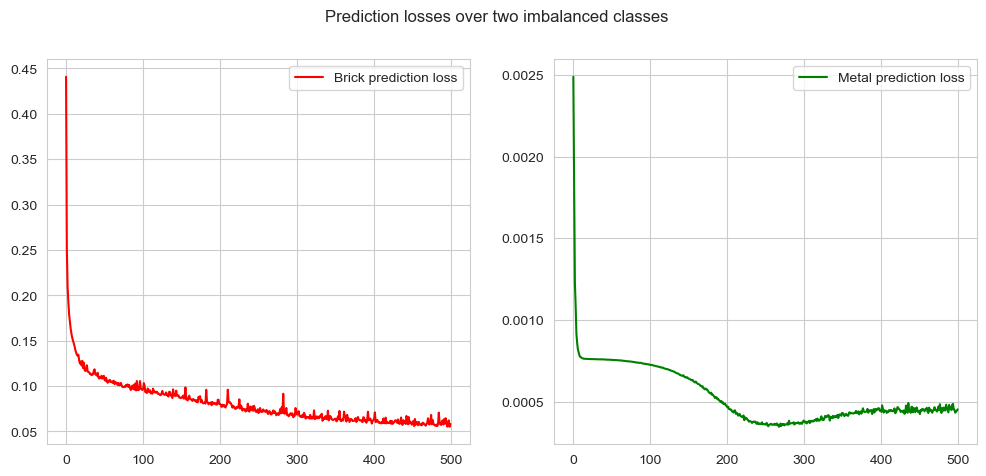

In [228]:

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plt.suptitle("Prediction losses over two imbalanced classes")

axes[0].plot(test_losses_history[:,0], color="red", label="Brick prediction loss")
axes[0].legend()

axes[1].plot(test_losses_history[:,1], color="green", label="Metal prediction loss")
axes[1].legend()

plt.show()

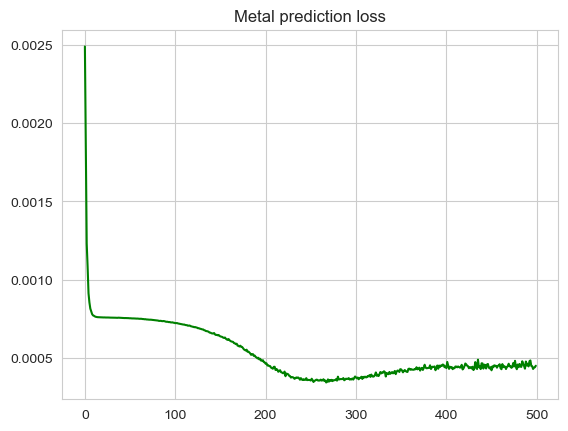

In [217]:
plt.plot(test_losses_history[:,1], color="green")
plt.title("Metal prediction loss")

plt.show()

# 1. Obtaining predictions for `test set` using a `trained model`

In [1]:
#f"{model_path}/encoder_350.pt".split("/")[-1].removesuffix(".pt").split("_")[-1]

#"/".join(f"{model_path}/encoder_350.pt".split("/")[:-1])#.removesuffix(".pt").split("_")[-1]


# Final Semantics:
data_path           = "./utils/assets/data/semantics_final/test_set_15000.json"
trained_model_path  = "./utils/assets/data/semantics_final/models/encoder_1000.pt"
category_names      = ['building', 'water', 'road', 'sidewalk', 'surface', 'tree', 'sky', 'miscellaneous']
colors              = ["#ffffe5", "#e5f5f9", "#ccece6", "#99d8c9", "#66c2a4", "#41ae76", "#238b45", "#005824"]# https://colorbrewer2.org/#type=sequential&scheme=BuGn&n=8


# # Semantics:
# data_path           = "./utils/assets/data/splits_physical/test_set_4800.json"
# trained_model_path  = "./utils/assets/data/splits_physical/models/encoder_350.pt"

# # Full Semantics:
# data_path           = "./utils/assets/data/full_semantics/test_set_4800.json"
# trained_model_path  = "./utils/assets/data/full_semantics/models/encoder_1000.pt"

# Perception:
# data_path          = "./utils/assets/data/perception_metrics/test_set_4800.json"
# trained_model_path = "./utils/assets/data/perception_metrics/models/encoder_350.pt"


# category_names = ['building', ' water', 'tree', 'sky']# semantics #[' building' ' water' ' road ' ' sidewalk' ' surface' ' tree' ' sky']
# colors = ["darkslategrey", "navy", "forestgreen", "deepskyblue"]
# category_names = ["greenness", "openness", "imageability", "enclosure", "walkability", "serenity"] #perception metrics
# colors = None# ["forestgreen", "deepskyblue", "fuchsia", "darkslategrey", "darkgoldenrod", "navy"]


In [1]:
from utils.scripts.architectures.torch_nerf_src import network

import pandas as pd
import torch

'''
load_model_from_info_dict_path - Moved to Visibility_Encoder/utils/test_location_encoder.py - 02.20.2025
'''

def load_model_from_info_dict_path(info_dict_path):
    '''
    Load trained model based on info dictionary.
    '''
    
    # Initialize NeRFS model with weights of trainedNeRF model
    info_dict       = pd.read_json(info_dict_path).to_dict()[0]
    print("Found the following non empty classes:\n\t", info_dict["non_empty_classes_names"])
    # return info_dict
    norm_params     = (torch.tensor(info_dict["xyz_centroid"]), torch.tensor(info_dict["xyz_max-min"]), torch.tensor(info_dict["xyzh_centroid"]), torch.tensor(info_dict["xyzh_max-min"]))

    trained_model_path = info_dict_path.replace("training_info_", "encoder_").replace(".json", ".pt")
    trained_encoder            = network.nerfs.NeRFS(norm_params=norm_params, surface_type="square", pos_dim=info_dict["enc_input_size"], output_dim=info_dict["num_present_classes"],  view_dir_dim=info_dict["enc_input_size"])
    trained_encoder.load_state_dict(torch.load(trained_model_path))
    
    return trained_encoder, info_dict


# info_dict_path = "./utils/assets/data/semantics_final/models/training_info_1000.json"
# info_dict_path = "./utils/assets/data/buildings_outlier/models/training_info_350.json"
# info_dict_path = "./utils/assets/data/buildings_outlier/models/training_info_1000.json"
# data_path           = "./utils/assets/data/buildings_outlier/test_set_5340.json"

#Semantics:
info_dict_path      = "./utils/assets/data/semantics/models/training_info_1000.json"
trained_model_path  = info_dict_path.replace("training_info_", "encoder_").replace(".json", ".pt")
data_path           = "./utils/assets/data/semantics/test.json"
train_data_path     = "./utils/assets/data/semantics/train.json"


#Building Outlier
# info_dict_path      = "./utils/assets/data/buildings_outlier/models/training_info_350.json"
# info_dict_path      = "./utils/assets/data/buildings_outlier/models/training_info_30.json"
# trained_model_path  = info_dict_path.replace("training_info_", "encoder_").replace(".json", ".pt")
# data_path           = "./utils/assets/data/buildings_outlier/test.json"
# train_data_path     = "./utils/assets/data/buildings_outlier/train.json"

#Building Data
# info_dict_path      = "./utils/assets/data/buildings/models/training_info_1000.json"
# trained_model_path  = info_dict_path.replace("training_info_", "encoder_").replace(".json", ".pt")
# data_path           = "./utils/assets/data/buildings/test.json"
# train_data_path     = "./utils/assets/data/buildings/train.json"


trained_encoder, info_dict = load_model_from_info_dict_path(info_dict_path)

Found the following non empty classes:
	 ['building', 'water', 'road', 'sidewalk', 'surface', 'tree', 'sky', 'miscellaneous']
Constructed tensor formulas: []
Surface not initialized properly. Can only predict from raw position and direction.


In [2]:
from utils.scripts.architectures.train_location_encoder \
import get_location_visibility_encoder, process_locations_visibility_data_frame\
, get_location_visibility_loaders, run_one_epoch_location_encoder, train_model_on_data

from tqdm import tqdm

from utils.scripts.architectures.torch_nerf_src import network

import numpy as np
import pandas as pd
import torch


from tqdm.notebook import tqdm

#######
##Copied to utils.test_location_encoder.py - 02.25.2025

from utils.test_location_encoder import get_hidden_layer_predictions

# def get_hidden_layer_predictions(data_path, trained_model_path, info_dict_path=None, frac=1, query_format=False):
#     '''
#     data_path - path to data file (test data dataframe) - as json file should work
#     trained_model_path - trained nerf
#     info_dict_path - if no path provided tries to match to an info_dict from the same folder.
    
#     returns model_predictions, model_latent_features
    
#     frac takes determinstically the first fraction of the data.
#     '''
#     model_folder = "/".join(trained_model_path.split("/")[:-1])
    
#     test_df = pd.read_json(data_path)
#     test_df = test_df.head(int(frac*test_df.shape[0]))
    
#     if info_dict_path is None: # try to find info_dict in the same folder as the model
#         try:
#             model_name   = trained_model_path.split("/")[-1]
#             model_version  = model_name.removesuffix(".pt").split("_")[-1]
#             info_dict_path = f"{model_folder}/training_info_{model_version}.json"
#         except:
#             print("There was no training info_dict found for provided model. Please provide separate info_dict_path.")
#             return

#     # Initialize NeRFS model with weights of trainedNeRF model
#     info_dict       = pd.read_json(info_dict_path).to_dict()[0]
#     print("Found the following non empty classes:\n\t", info_dict["non_empty_classes_names"])
#     # return info_dict
#     norm_params     = (torch.tensor(info_dict["xyz_centroid"]), torch.tensor(info_dict["xyz_max-min"]), torch.tensor(info_dict["xyzh_centroid"]), torch.tensor(info_dict["xyzh_max-min"]))

#     nerf_latent_features = []
#     nerf_predictions     = []

#     trained_encoder            = network.nerfs.NeRFS(norm_params=norm_params, surface_type="square", pos_dim=info_dict["enc_input_size"], output_dim=info_dict["num_present_classes"],  view_dir_dim=info_dict["enc_input_size"])
#     trained_encoder.load_state_dict(torch.load(trained_model_path))
    
#     if "label_name" in info_dict:
#         test_df["f_xyz"] = test_df[info_dict["label_name"]]
        
#     print("Succesful model intialization and data loading.\nPredicting hidden layers...")
#     #Get hidden layer for each sample in the dataset
#     for i in tqdm(range(test_df.shape[0])):
#         xyz  = torch.tensor(test_df.values[:,:6][i].astype(float)[:3])
#         xyzh = torch.tensor(test_df.values[:,:6][i].astype(float)[3:])

#         _, latent_features, prediction = trained_encoder.predict_from_raw(xyz, xyzh, return_latent_features=True)


#         nerf_predictions.append(prediction.detach().numpy()[0])
#         nerf_latent_features.append(latent_features.detach().numpy())
#     #     break

#     nerf_predictions     = np.vstack(nerf_predictions)
#     nerf_latent_features = np.vstack(nerf_latent_features)
    
#     print("Succesfully inferred hidden layer values for provided test set.")
    
#     print("\nThe last prediction was:", prediction)
#     print("The non empty classes are:", info_dict["non_empty_classes_names"])
    
#     #return nerf_predictions, nerf_latent_features, test_df, trained_encoder
#     if query_format:
#         if test_df["f_xyz"].apply(lambda x: type(x)==str).values[0]:
#             test_df["f_xyz_raw"] = test_df["f_xyz"].apply(eval)
#             test_df["f_xyz"]     = test_df["f_xyz_raw"].apply(lambda d: [s/sum(d) for s in d]) 
#         #else:
#         #Assumes test_df["f_xyz"] is already normalized and between -1, 1 / with process_locations_visibility_data_frame already applied
#         test_df["f_xyz"] = test_df["f_xyz"].apply(lambda fs:
#                                                   {k : v for k, v in 
#                                                    zip(info_dict["classes_names"], [(1 + f)/2 for f in fs]) 
#                                                    if k in info_dict["non_empty_classes_names"]})
        
#         #torch.nn.MSELoss()(desired_percentages, actual_percentages).mean()
#         test_df["residual"]    = 0
#         test_df["steps"]       = 0
#         test_df["start_locs"]  = test_df.apply(lambda r: [r["x"], r["y"], r["z"]], axis=1)
#         test_df["start_views"] = test_df.apply(lambda r: [r["xh"], r["yh"], r["zh"]], axis=1)
        
# #     [dict(zip(info_dict["non_empty_classes_names"], d["predictions"][-1])) for d in debug_dicts] 
    
# #     return nerf_predictions, nerf_latent_features, test_df
#     return nerf_predictions, nerf_latent_features, test_df, trained_encoder
    

# nerf_predictions.shape, nerf_latent_features.shape


# pv, latent_features, prediction
frac = 1 
# frac = .5
# frac = 0.01#.01# Just for testing speed

nerf_predictions, nerf_latent_features, test_df, trained_encoder = \
get_hidden_layer_predictions(data_path, trained_model_path, info_dict_path=None, frac=frac, query_format=True)#[2]



# get_hidden_layer_predictions(data_path, trained_model_path, info_dict_path=None, frac=frac, query_format=True)[2].f_xyz.values[0]



# train_nerf_predictions, train_nerf_latent_features, train_df, _ = \
# get_hidden_layer_predictions(train_data_path\
#                              , trained_model_path\
#                              , info_dict_path=None\
#                              , frac=frac\
#                              , query_format=True)#[2]


Found the following non empty classes:
	 ['building', 'water', 'road', 'sidewalk', 'surface', 'tree', 'sky', 'miscellaneous']
Constructed tensor formulas: []
Surface not initialized properly. Can only predict from raw position and direction.
Succesful model intialization and data loading.
Predicting hidden layers...


  4%|███████▎                                                                                                                                                                | 383/8740 [00:02<00:51, 163.17it/s]


KeyboardInterrupt: 

In [12]:
train_df["f_xyz"] = train_df["f_xyz"].apply(lambda fs: dict(zip(info_dict["non_empty_classes_names"], [(1 + f)/2 for f in fs])))




In [13]:
test_df["f_xyz"]#.apply(lambda x: type(x)==str)

0     [-0.6203162639, -1.0, -1.0, -1.0, -1.0, 0.6203...
1     [-0.7976829583, -1.0, -1.0, -1.0, -0.996565412...
2                   [-1.0, -1.0, -1.0, -1.0, -1.0, 1.0]
3     [-0.7695172525, -1.0, -1.0, -1.0, -0.996742883...
4     [-0.9863608248000001, -1.0, -1.0, -1.0, -1.0, ...
                            ...                        
82                  [-1.0, -1.0, -1.0, -1.0, -1.0, 1.0]
83    [-0.9724241246, -1.0, -1.0, -1.0, -1.0, 0.9724...
84    [-0.7372331735000001, -1.0, -1.0, -1.0, -1.0, ...
85    [-0.7813503984, -1.0, -1.0, -1.0, -1.0, 0.7813...
86    [-0.9628667845000001, -1.0, -1.0, -1.0, -1.0, ...
Name: f_xyz, Length: 87, dtype: object

# Moved to `gradient_walk_utils.py` November 2024

In [3]:

def project_data_on_2d(global_data, projector=None, query_data=None):
    '''
    global_data: (n, hidden_dim) - projector trainging features - NN hidden layer 
    prjoector: sklearn 2d projector - PCA, TSNE, UMAP
    new_data: (m, hidden_dim) - projector transform features - NN hidden layer 
    '''

    #if projector.__class__.__name__ == "TSNE":##TODO / TSNE does not have .transform()
    
    from sklearn.utils.validation import check_is_fitted
    try:
        check_is_fitted(projector)
        print(f"{projector.__class__.__name__} already fitted.")
        projected_results_global = projector.transform(global_data)
    except:
        print(f"Fitting not fitted {projector.__class__.__name__}...")
        projected_results_global = projector.fit_transform(global_data)
    
    if query_data is not None:
        projected_results_query = projector.transform(query_data)
        return projector, (projected_results_global, projected_results_query)
    

    return projector, projected_results_global

def use_fitted_projector(latent_features, projector_name, model_path):
    '''
    Project latent features into 2d using trained 2d projector taken from the same path as a trained model.
    latent_features: (n, n_features) numpy array
    projector_name: UMAP or PCA
    model_path: path to trained encoder model
    '''
    import joblib
    
    projector_path         = model_path.replace("/encoder_", f"/{projector_name}_").replace(".pt", ".pkl")
    projector              = joblib.load(projector_path)
    projector, projections = project_data_on_2d(latent_features, projector)

    print(f"{projector.__class__.__name__} projection -- OK.")
    
    return projections.tolist()



# Compute predictions and Latent projections for all the separate physical locations in test_df.json

Data generation steps:

1. Download from the semnatic interface - csv format: x,y,z,xh,yh,zh,f_xyz,image_name
2. Perform physical splits between as train and test separate locations : Check `./NeRF_vs_Vanilla_Physical_Splits_Interpolator_experiment.ipynb`
3. Train model on train locations and Compute Predctions on the separate test physical locations.
4. Compute zip assignment for each location base on the knn `locations_to_zip(xyz_locations)` method in `gradient_walk_utils.py`

In [7]:

from sklearn.utils.validation import check_is_fitted
from sklearn.decomposition import PCA
from time import time
import umap
import joblib
from utils.gradient_walk_utils import locations_to_zip


nerf_predictions, nerf_latent_features, test_df, trained_encoder = \
get_hidden_layer_predictions(data_path, trained_model_path, info_dict_path=None, frac=1, query_format=True)

projectors = [PCA(n_components=2), umap.UMAP(n_components=2, n_neighbors=15)]

test_df["zip"] = locations_to_zip(test_df[["x", "y", "z"]].values.tolist()) #Same application method as in `gradient_walk_utils.py`

for projector in projectors:

    start_time = time()

    projector, projected_results_global = project_data_on_2d(global_data = nerf_latent_features, projector=projector, query_data=None)
    
    projector_name = projector.__class__.__name__
    
    #projections = use_fitted_projector(projected_results_global, projector_name, model_path)
    
    projector_path = trained_model_path.replace("/encoder_", f"/{projector_name}_").replace(".pt", ".pkl")
    joblib.dump(projector, projector_path) 

    test_df[projector_name] = projected_results_global.tolist()
    print(f"{projector_name} projection took {time() -  start_time:.2f}s")
    print("Example projection: ", projected_results_global[0],"\n")
    


Found the following non empty classes:
	 ['brick', 'metal']
Constructed tensor formulas: []
Surface not initialized properly. Can only predict from raw position and direction.
Succesful model intialization and data loading.
Predicting hidden layers...


  0%|          | 0/5340 [00:00<?, ?it/s]

Succesfully inferred hidden layer values for provided test set.

The last prediction was: tensor([[-0.8478, -1.0000]], grad_fn=<TanhBackward0>)
The non empty classes are: ['brick', 'metal']
Fitting not fitted PCA...
PCA projection took 0.05s
Example projection:  [-3.6887019 -1.0661088] 

Fitting not fitted UMAP...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


UMAP projection took 33.53s
Example projection:  [-1.4699754 10.332152 ] 



#### test_df.groupby("zip").count()

In [6]:
#prediction example and nubmer of physically distinct locations
test_df.f_xyz.values[0], test_df.shape[0] // 6

({'building': 0.528912037,
  'water': -1.0,
  'road': -1.0,
  'sidewalk': -1.0,
  'surface': -1.0,
  'tree': -1.0,
  'sky': -0.528912037,
  'miscelaneous': -1.0},
 2500)

In [11]:
#prediction example and nubmer of physically distinct locations
test_df.f_xyz.values[0], test_df.shape[0] // 6

({'building': 0.7644560185,
  'water': 0.0,
  'road': 0.0,
  'sidewalk': 0.0,
  'surface': 0.0,
  'tree': 0.0,
  'sky': 0.2355439815,
  'miscelaneous': 0.0},
 2500)

In [10]:
test_json_path = trained_model_path[:trained_model_path.index("models/")] + "test_set_as_query.json"

test_df.to_json(test_json_path, indent=4, orient="records")

print(", ". join([p.__class__.__name__ for p in projectors]), f" test set projections saved at: \n\t{test_json_path}")

PCA, UMAP  test set projections saved at: 
	./utils/assets/data/semantics_final/test_set_as_query.json


# Others: Test how __partial query__ can be rectified to --> __full distribution__.

In [43]:
import numpy as np

semantics_pricipal   = ['building', 'water', 'tree', 'sky'] #[' building' ' water' ' road ' ' sidewalk' ' surface' ' tree' ' sky']

desired_distribution = {'water':.5, 'tree':.2}

semantics_pricipal   = ["greenness", "openness", "imageability", "enclosure", "walkability", "serenity"]

desired_distribution = {'enclosure':.5, 'openness':.2}


labels, label_ids, query_ids = np.intersect1d(semantics_pricipal, list(desired_distribution.keys()), return_indices=True)


labels, label_ids, query_ids

rectified_distribution = np.zeros_like(semantics_pricipal, dtype=float) - 1

rectified_distribution[label_ids] = [desired_distribution[semantics_pricipal[qi]] for qi in label_ids]

rectified_distribution, label_ids, labels, query_ids

print("Specified distribution:", desired_distribution)
print("Rectified distribution:", dict(zip(semantics_pricipal, rectified_distribution)))



Specified distribution: {'enclosure': 0.5, 'openness': 0.2}
Rectified distribution: {'greeness': -1.0, 'openness': 0.2, 'imageability': -1.0, 'enclosure': 0.5, 'walkability': -1.0, 'serenity': -1.0}


# Original projection code snippets

In [75]:

from sklearn.utils.validation import check_is_fitted
from sklearn.decomposition import PCA
from time import time
import umap
import joblib


# nerf_predictions, nerf_latent_features, test_df, trained_encoder = \
# get_hidden_layer_predictions(data_path, trained_model_path, info_dict_path=None, frac=1, query_format=True)

projectors = [PCA(n_components=2), umap.UMAP(n_components=2, n_neighbors=200, min_dist=.5)]

# PCA transformation
start_time = time()
# projector  = PCA(n_components=2)
projector=projectors[0]
# projector  = joblib.load("./utils/assets/data/perception_metrics/models/PCA_350.pkl")
# projector  = joblib.load("./utils/assets/data/splits_physical/models/PCA_350.pkl")
# projector_name = projector.__class__.__name__
# projector_path         = model_path.replace("/encoder_", f"/{projector_name}_").replace(".pt", ".pkl")
projector, (global_projections, query_projections) = project_data_on_2d(nerf_latent_features, projector, nerf_latent_features)
#Save projector
projector_name = projector.__class__.__name__
projector_path = trained_model_path.replace("/encoder_", f"/{projector_name}_").replace(".pt", ".pkl")
joblib.dump(projector, projector_path) 
#Store projections id DF 
test_df[projector.__class__.__name__] = global_projections.tolist()
print(f"PCA projection took {time() -  start_time:.2f}s")
print(query_projections[0],"\n")

# UMAP transformation
start_time = time()
# projector  = umap.UMAP(n_components=2, n_neighbors=15)
projector=projectors[1]
# projector  = joblib.load("./utils/assets/data/perception_metrics/models/UMAP_350.pkl")
# projector  = joblib.load("./utils/assets/data/splits_physical/models/UMAP_350.pkl")
projector, (global_projections, query_projections) = project_data_on_2d(nerf_latent_features, projector, nerf_latent_features)
#Save projector
projector_name = projector.__class__.__name__
projector_path = trained_model_path.replace("/encoder_", f"/{projector_name}_").replace(".pt", ".pkl")
joblib.dump(projector, projector_path) 
#Store projections id DF 
test_df[projector.__class__.__name__] = global_projections.tolist()
print(f"UMAP projection took {time() -  start_time:.2f}s")

# test_df.head()
print(query_projections[0])

Fitting not fitted PCA...
PCA projection took 0.09s
[-3.6887028 -1.0660863] 

Fitting not fitted UMAP...
UMAP projection took 26.55s
[-8.33338   -0.5383415]


In [11]:
# test_df.to_json("./utils/assets/data/perception_metrics/test_set_as_query_perception.json", indent=4, orient="records")
# test_df.to_json("./utils/assets/data/splits_physical/test_set_as_query_semantics.json", indent=4, orient="records")
# test_df.to_json("./utils/assets/data/full_semantics/test_set_as_query_full_semantics.json", indent=4, orient="records")
# test_df.to_json("./utils/assets/data/perception_metrics/test_set_as_query.json", indent=4, orient="records")


trained_model_path.replace("/encoder_", f"/{projector.__class__.__name__}_").replace(".pt", ".pkl")


'./utils/assets/data/perception_metrics/models/UMAP_350.pkl'

# Helpers

In [21]:
from sklearn.utils.validation import check_is_fitted

try:
    check_is_fitted(projector)
except:
    print("Not fitted.")
    
import joblib

# save
joblib.dump(projector, "model.pkl") 

# load
clf2 = joblib.load("model.pkl")

from time import time
time() - time()

projector.__class__.__name__ == "TSNE"

Not fitted.


# Plots

In [175]:
print(test_df.head(1).to_json(indent=4, orient="records"))

[
    {
        "x":2089.3714992676,
        "y":74.6259150505,
        "z":391.8669587708,
        "xh":168.9054564731,
        "yh":57.696009797,
        "zh":-170.589183676,
        "f_xyz":{
            "greenness":0.0297651291,
            "openness":0.4966688156,
            "imageability":0.469877243,
            "enclosure":0.9925366771,
            "walkability":0.4795369988,
            "serenity":0.4978694916
        },
        "image_name":"pos558-0-visibility-70",
        "xn":0.2193325857,
        "yn":0.0040614215,
        "zn":-0.2240769686,
        "xhn":0.4075582523,
        "yhn":0.0534508696,
        "zhn":-0.4315468606,
        "f_xyz_raw":[
            492631,
            0,
            1259,
            1449,
            1160,
            31211,
            520795,
            71
        ],
        "greeness":0.0297651291,
        "openness":0.4966688156,
        "imageability":0.469877243,
        "encolusre":0.9925366771,
        "walkability":0.4795369988,
   

# 2. Plots: Generic projection based on predictions and color categories:

In [4]:
import numpy as np
from sklearn.decomposition import PCA
import umap
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')



def project_data_on_2d_plot(data, projector, categories=None, category_names=None\
           , colors=None, density_plot=False, hexbin=False):
    '''
    prjoector: sklearn 2d projector - PCA, TSNE, UMAP
    data: (n, num_dimensions) - hidden features - NN hidden layer 
    categories: (n, 1) - array with values 0-k category of each of the n samples.
                    If None, all are assigned the same category.
    category_names: (k) - list with names of the k cateogories.
    
    returns: plot and projected data.
    '''
    
    projected_results = projector.fit_transform(data)
    
    if categories is None:
        categories = np.zeros(data.shape[0]).astype(int)
    # Generate a color map based on categories
    unique_categories = np.arange(categories.max() + 1) #np.arange(categories.shape[1])#np.unique(categories)
    if colors is None:
        colors            = ["blue" for i in range(categories.shape[0])]
#     else:
#         plt.legend()
#         colors            = ["blue" for i in range(len(unique_categories))]
        #colors            = plt.cm.rainbow(np.linspace(0, 1, len(unique_categories)))
    print("category_names", category_names)
    if category_names is None or (len(unique_categories)!=len(category_names)):
        print(":unique_categories", (unique_categories), "\ncategory_names:", (category_names))
        category_names = unique_categories.astype(str)
    
    print("category_names", category_names)
#     print(category_names, categories, colors)
    if hexbin:
        plt.hexbin(projected_results[:, 0], projected_results[:, 1], gridsize=30, cmap='Blues', alpha=0.75)
    else:
        # Scatter plot with color coding
        for i, category in enumerate(unique_categories):
            plt.scatter(projected_results[categories == category, 0], projected_results[categories == category, 1], 
                        color=colors[i], label=f'{category_names[category]}', alpha=.45)
            plt.legend()

    if density_plot:
        from scipy.stats import gaussian_kde
        x, y = projected_results[:, 0], projected_results[:, 1]
        k = gaussian_kde([x, y])
        xi, yi = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
        zi = k(np.vstack([xi.flatten(), yi.flatten()]))
        plt.contour(xi, yi, zi.reshape(xi.shape), levels=10, cmap="Blues", alpha=0.5)

    plt.xlabel(f'{projector.__class__.__name__} 1')
    plt.ylabel(f'{projector.__class__.__name__} 2')
    plt.title(f'{projector.__class__.__name__} of Multidimensional Data with Categories')
    plt.show()
    
    return projector, projected_results




# Model, Data -> Projected Latent Features - Assembled pipeline

In [39]:
test_df["f_xyz"].values[0]

{' building': 0.528912037,
 ' water': -1.0,
 ' road ': -1.0,
 ' sidewalk': -0.528912037}

In [32]:
np.arange(np.unique(categories).shape[0])

array([0, 1, 2, 3, 4, 5, 6])

In [23]:
categories

array([0, 0, 0, 0, 7, 7, 6, 0, 7, 6, 6, 2, 0, 0, 0, 6, 6, 0, 7, 2, 2, 7, 2, 2, 6, 7, 1, 1, 1, 1, 6, 4, 4, 1, 5, 4, 6, 0, 7, 6, 6, 7, 6, 5, 1, 6, 1, 1, 6, 0, 0, 6, 6, 0, 1, 1, 1, 1, 1, 1, 6, 0, 7, 6, 0, 7, 0, 0, 7, 0, 7, 7, 6, 4, 1, 1, 5, 5, 6, 5, 1, 6, 5, 5, 6, 7, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 7, 7, 6, 5, 5, 5, 6, 5, 0, 0, 0, 0, 0, 7, 6, 4, 1, 1, 7, 2, 6, 4, 4, 4, 5, 5, 6, 7, 0, 6, 6, 6, 6, 0, 1, 1, 1, 1, 0, 0, 7, 0, 0, 0, 6, 1, 1, 6, 6, 5])

In [31]:
np.unique(pr_percentages.round(2).argmax(1))

array([0, 5])

In [42]:
(nerf_predictions>-.99).astype(int).max(0)

array([1, 1, 0, 0, 0, 1])

In [44]:
np.where(nerf_predictions<-.99, -np.inf, nerf_predictions)

array([[ 0.22418483,        -inf,        -inf,        -inf,        -inf,
        -0.20837367],
       [ 0.62494   ,        -inf,        -inf,        -inf,        -inf,
        -0.6029081 ],
       [ 0.7641673 ,        -inf,        -inf,        -inf,        -inf,
        -0.76155   ],
       ...,
       [-0.98853   ,        -inf,        -inf,        -inf,        -inf,
         0.98948896],
       [-0.9732609 ,        -inf,        -inf,        -inf,        -inf,
         0.9765904 ],
       [-0.96788305,        -inf,        -inf,        -inf,        -inf,
         0.971973  ]], dtype=float32)

In [63]:
np.vstack(test_df["f_xyz"][np.vstack(test_df["f_xyz"].apply(lambda x: list(x.values()))).argmax(axis=1)==1].apply(lambda x: list(x.values()))).round(2)

array([[0.  , 0.  ],
       [0.06, 0.09],
       [0.1 , 0.3 ],
       [0.17, 0.41],
       [0.27, 0.27],
       [0.  , 0.  ],
       [0.04, 0.06],
       [0.08, 0.1 ],
       [0.  , 1.  ],
       [0.21, 0.71],
       [0.3 , 0.44]])

In [58]:
pr_percentages[pr_percentages.argmax(axis=1)==1]

array([[0.07948473, 0.27107382],
       [0.29104275, 0.37427092],
       [0.15130582, 0.24305606]], dtype=float32)

In [240]:
pr_percentages[:,1].shape, pr_percentages[pr_percentages[:,1] > .0005].shape

((5340,), (341, 2))

In [242]:
np.where(pr_percentages[:,1]>0.05, pr_percentages[:,1] * 5, pr_percentages[:,1]).shape

(5340,)

(2500.0, 0.0)

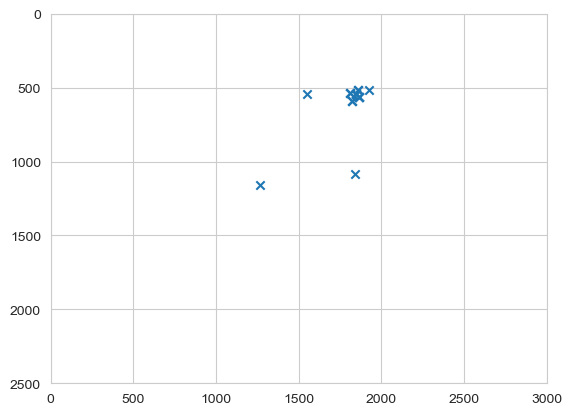

In [301]:
plt.scatter(test_df[test_df["metal_prediction"]>0.02]["x"], test_df[test_df["metal_prediction"]>0.02]["z"], marker="x")
plt.xlim(0, 3000)
plt.ylim(2500, 0)

(2500.0, 0.0)

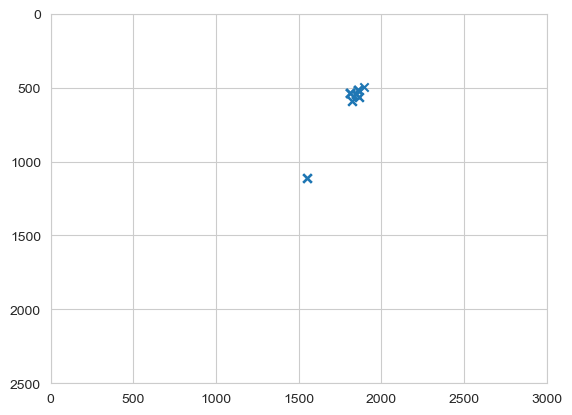

In [288]:
plt.scatter(train_df[train_df["metal_prediction"]>0.05]["x"], train_df[train_df["metal_prediction"]>0.05]["z"], marker="x")
plt.xlim(0, 3000)
plt.ylim(2500, 0)

(2500.0, 0.0)

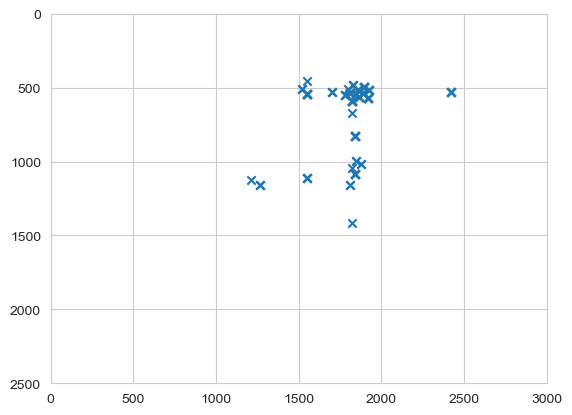

In [283]:
plt.scatter(train_df[train_df["metal_prediction"]>0.01]["x"], train_df[train_df["metal_prediction"]>0.01]["z"], marker="x")
plt.xlim(0, 3000)
plt.ylim(2500, 0)

(2500.0, 0.0)

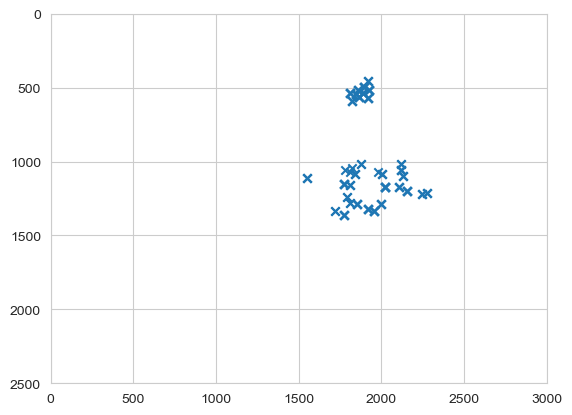

In [282]:
plt.scatter(train_df[train_df["metal_presence"]>0.01]["x"], train_df[train_df["metal_presence"]>0.01]["z"], marker="x")
plt.xlim(0, 3000)
plt.ylim(2500, 0)

In [254]:
test_df["metal_prediction"].max()

100.0

In [ ]:
train_df[]

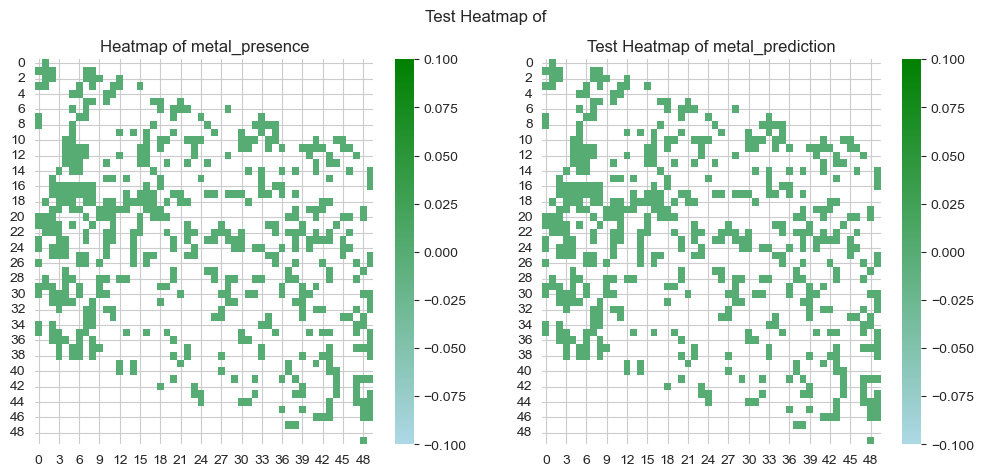

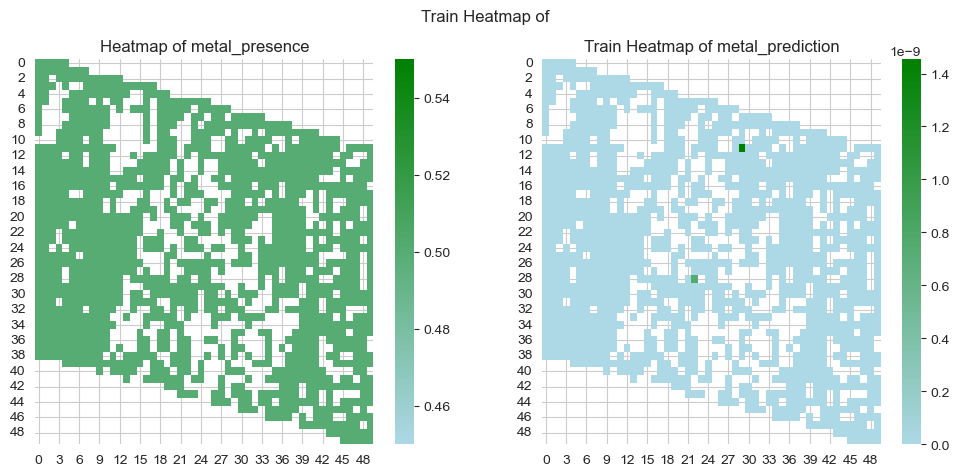

In [13]:
# !pip uninstall plotly -y
# import plotly.express as px

from scipy.stats import binned_statistic_2d


pr_percentages = nerf_predictions / 2 + .5

test_df["brick_prediction"] = pr_percentages[:,0]
test_df["metal_prediction"] = pr_percentages[:,1]
# test_df["metal_prediction"] = np.where(pr_percentages[:,1]>0.05, 100, pr_percentages[:,1])

test_df["brick_presence"] = np.vstack(test_df["f_xyz"].apply(lambda x: list(x.values())))[:,0]
test_df["metal_presence"] = np.vstack(test_df["f_xyz"].apply(lambda x: list(x.values())))[:,1]

# fig1 = px.density_heatmap(test_df, x="x", y="y", z="brick_prediction", nbinsx=50, nbinsy=50, color_continuous_scale="viridis")
# fig1.show()


def generate_comparative_heatmaps(df, presence_label, prediction_label, color, header="Heatmap of"):
    # Create 2D Heatmap bins
    num_bins = 50  # Adjust resolution

    # Compute heatmaps using binned_statistic_2d
    heatmap_v1, x_edges, y_edges, _ = binned_statistic_2d(df['x'], df['z'], df[presence_label]\
                                                          , statistic='mean', bins=num_bins)
    heatmap_v2, _, _, _ = binned_statistic_2d(df['x'], df['z'], df[prediction_label]\
                                              , statistic='mean', bins=num_bins)

    # Plot Heatmaps
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    for ax, heatmap, title in zip(axes, [heatmap_v1, heatmap_v2], [f'Heatmap of {presence_label}', f'{header} {prediction_label}']):
    #     ax.invert_yaxis()
    #     sns.heatmap(np.flipud(heatmap.T), cmap="Spectral_r", ax=ax)
        sns.heatmap((heatmap.T), cmap=sns.blend_palette(["lightblue", color], as_cmap=True), ax=ax)
    #     sns.heatmap((heatmap.T), cmap=sns.blend_palette(["lightblue", "red"], as_cmap=True), ax=ax)

        ax.set_title(title)
    plt.suptitle(header)
    plt.show()
    
generate_comparative_heatmaps(test_df, "metal_presence", "metal_prediction", color="green", header="Test Heatmap of")
# generate_comparative_heatmaps(test_df, "brick_presence", "brick_prediction", color="red")


train_df["brick_prediction"] = (train_nerf_predictions / 2 + .5)[:,0]
train_df["metal_prediction"] = (train_nerf_predictions / 2 + .5)[:,1]
# train_df["metal_prediction"] = np.where((train_nerf_predictions / 2 + .5)[:,1]>0.05, 100,(train_nerf_predictions / 2 + .5)[:,1])

train_df["brick_presence"] = np.vstack(train_df["f_xyz"].apply(lambda x: list(x.values())))[:,0]
train_df["metal_presence"] = np.vstack(train_df["f_xyz"].apply(lambda x: list(x.values())))[:,1]
generate_comparative_heatmaps(train_df, "metal_presence", "metal_prediction", color="green", header="Train Heatmap of")


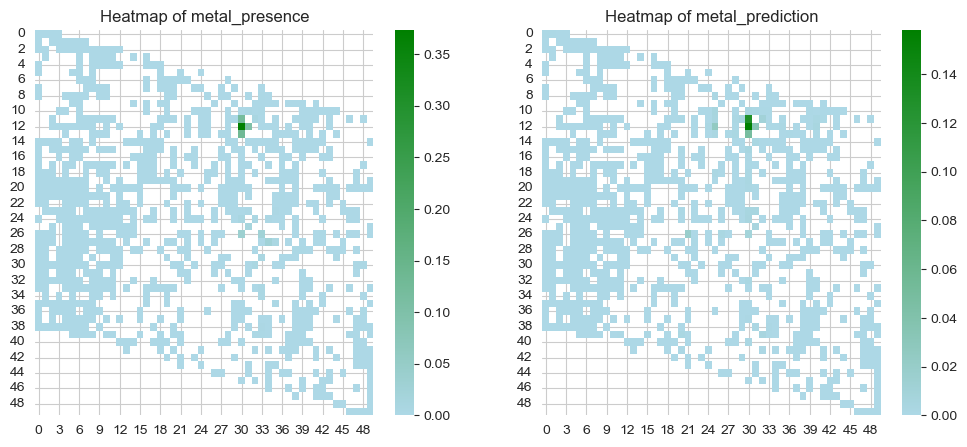

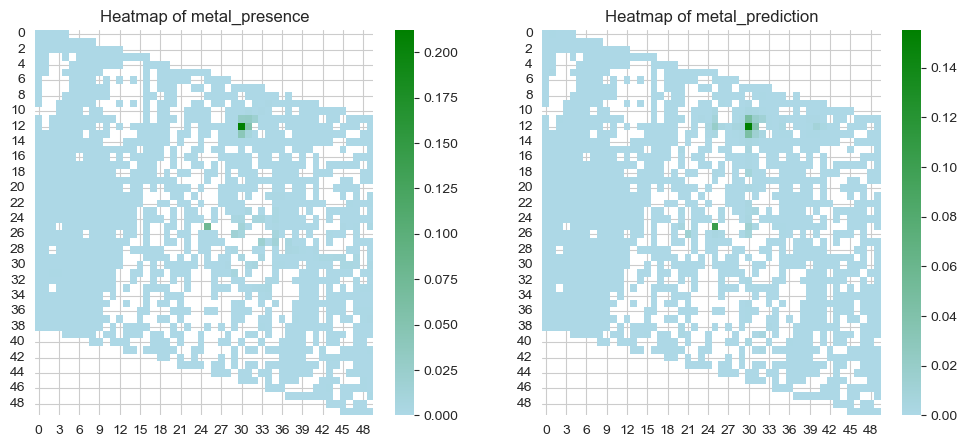

In [287]:
# !pip uninstall plotly -y
# import plotly.express as px

from scipy.stats import binned_statistic_2d


pr_percentages = nerf_predictions / 2 + .5

test_df["brick_prediction"] = pr_percentages[:,0]
test_df["metal_prediction"] = pr_percentages[:,1]
# test_df["metal_prediction"] = np.where(pr_percentages[:,1]>0.05, 100, pr_percentages[:,1])

test_df["brick_presence"] = np.vstack(test_df["f_xyz"].apply(lambda x: list(x.values())))[:,0]
test_df["metal_presence"] = np.vstack(test_df["f_xyz"].apply(lambda x: list(x.values())))[:,1]

# fig1 = px.density_heatmap(test_df, x="x", y="y", z="brick_prediction", nbinsx=50, nbinsy=50, color_continuous_scale="viridis")
# fig1.show()


def generate_comparative_heatmaps(df, presence_label, prediction_label, color, header="Heatmap of"):
    # Create 2D Heatmap bins
    num_bins = 50  # Adjust resolution

    # Compute heatmaps using binned_statistic_2d
    heatmap_v1, x_edges, y_edges, _ = binned_statistic_2d(df['x'], df['z'], df[presence_label]\
                                                          , statistic='mean', bins=num_bins)
    heatmap_v2, _, _, _ = binned_statistic_2d(df['x'], df['z'], df[prediction_label]\
                                              , statistic='mean', bins=num_bins)

    # Plot Heatmaps
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    for ax, heatmap, title in zip(axes, [heatmap_v1, heatmap_v2], [f'Heatmap of {presence_label}', f'{header} {prediction_label}']):
    #     ax.invert_yaxis()
    #     sns.heatmap(np.flipud(heatmap.T), cmap="Spectral_r", ax=ax)
        sns.heatmap((heatmap.T), cmap=sns.blend_palette(["lightblue", color], as_cmap=True), ax=ax)
    #     sns.heatmap((heatmap.T), cmap=sns.blend_palette(["lightblue", "red"], as_cmap=True), ax=ax)

        ax.set_title(title)
    plt.suptitle(header)
    plt.show()
    
generate_comparative_heatmaps(test_df, "metal_presence", "metal_prediction", color="green", header="Test Heatmap of")
# generate_comparative_heatmaps(test_df, "brick_presence", "brick_prediction", color="red")


train_df["brick_prediction"] = (train_nerf_predictions / 2 + .5)[:,0]
train_df["metal_prediction"] = (train_nerf_predictions / 2 + .5)[:,1]
# train_df["metal_prediction"] = np.where((train_nerf_predictions / 2 + .5)[:,1]>0.05, 100,(train_nerf_predictions / 2 + .5)[:,1])

train_df["brick_presence"] = np.vstack(train_df["f_xyz"].apply(lambda x: list(x.values())))[:,0]
train_df["metal_presence"] = np.vstack(train_df["f_xyz"].apply(lambda x: list(x.values())))[:,1]
generate_comparative_heatmaps(train_df, "metal_presence", "metal_prediction", color="green", header="Train Heatmap of")


In [398]:
# test_df

In [487]:
common_coverage

60.0

In [509]:
(np.abs(prediction_heatmap-presence_heatmap) < 0.05).sum()

612

['building',
 'water',
 'road',
 'sidewalk',
 'surface',
 'tree',
 'sky',
 'miscellaneous']

297 325 297 0.9138461538461539


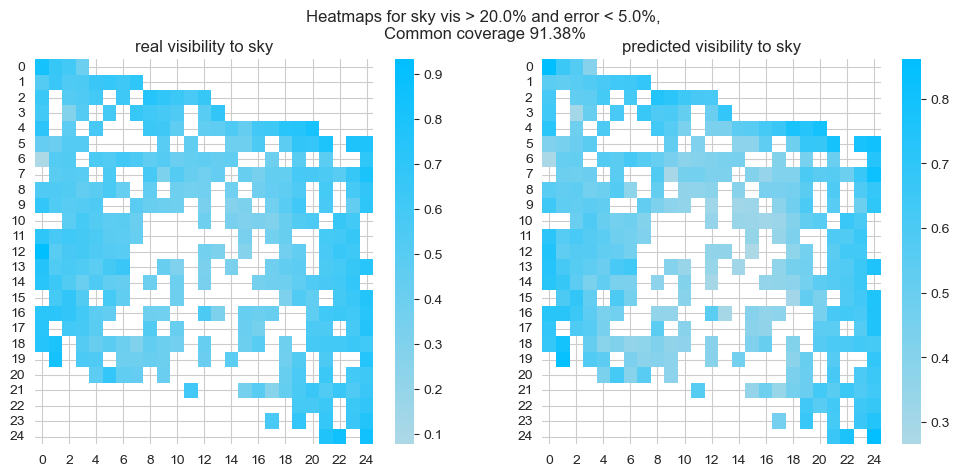

In [59]:
from functools import reduce

from scipy.stats import binned_statistic_2d
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")



semantics_to_colors = {
    'brick': 'red'
    ,'concrete':"grey", 'marble':"gold", 'plaster':"purple"
    , "metal": "forestgreen"
    ,"building" : "lightcoral" # Building color palette / ##DCDCDC
    , "water" : "aqua" # water color palette / #c4e2fe
    , "road" : "lavenderblush" # road color palette / #FFFFFF
    , "sidewalk" : "lightgoldenrodyellow" # sidewalk color palette / #EBEADF
    , "surface" : "lawngreen" # surface color palette / #CDDDB6
    , "tree" : "chartreuse" # Tree color palette / #9DB97F
    , "sky" : "deepskyblue" # Sky color palette  / #C7CFF4
    , "miscellaneous" : "violet" # miscelaneous color palette
}

pr_percentages = nerf_predictions / 2 + .5

test_df["brick_prediction"] = pr_percentages[:,0]
test_df["brick_presence"] = np.vstack(test_df["f_xyz"].apply(lambda x: list(x.values())))[:,0]

pr_id = 6
pr_class = info_dict["non_empty_classes_names"][pr_id]
test_df[f"{pr_class}_prediction"] = pr_percentages[:,pr_id]
# test_df["metal_prediction"] = np.where(pr_percentages[:,1]>0.05, 100, pr_percentages[:,1])
test_df[f"{pr_class}_presence"] = np.vstack(test_df["f_xyz"].apply(lambda x: list(x.values())))[:,pr_id]

anzlyzed_feature = "brick" ; color="red"#["brick", "metal"]
anzlyzed_feature = pr_class; color=semantics_to_colors[anzlyzed_feature]#color="green"
titles = [f'real visibility to {anzlyzed_feature}', f'predicted visibility to {anzlyzed_feature}']
num_bins = 25#100#1000

prediction_heatmap = binned_statistic_2d(test_df['x'], test_df['z']\
                                         , test_df[f"{anzlyzed_feature}_prediction"], statistic='mean', bins=num_bins)[0]
presence_heatmap   = binned_statistic_2d(test_df['x'], test_df['z']\
                                         , test_df[f"{anzlyzed_feature}_presence"], statistic='mean', bins=num_bins)[0]

np.logical_and(presence_heatmap!=0, ~np.isnan(presence_heatmap)).sum() # bins with presence of metal
np.logical_and(prediction_heatmap!=0, ~np.isnan(prediction_heatmap)).sum() # bins with prediction of metal

#conditions
vis_thresold   = 0.2
error_thresold = 0.05
prediction_errors = np.abs(prediction_heatmap-presence_heatmap)
cond_pres = presence_heatmap > vis_thresold   #metal visibility presence larger than x%
# cond_pred = prediction_heatmap > vis_thresold #metal visibility prediction larger than x%
cond_pred = np.logical_and(prediction_heatmap > vis_thresold, prediction_errors < error_thresold) #metal visibility prediction larger than x%


conditions = [cond_pres, cond_pred]
# np.logical_and().sum()

print(reduce(lambda x, y: np.logical_and(x,y), conditions).sum(), cond_pres.sum(), cond_pred.sum()\
, reduce(lambda x, y: np.logical_and(x,y), conditions).sum() / cond_pres.sum())

predicted_coverage = np.logical_and(cond_pres, cond_pred).sum()
real_coverage      = cond_pres.sum()
common_coverage    = np.round(predicted_coverage / real_coverage * 100, 2)
vis_percentage     = np.round(vis_thresold*100, 2)
error_percentage   = np.round(error_thresold*100, 2)


fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap((presence_heatmap.T), cmap=sns.blend_palette(["lightblue", color], as_cmap=True), ax=axes[0])
sns.heatmap((prediction_heatmap.T), cmap=sns.blend_palette(["lightblue", color], as_cmap=True), ax=axes[1])
axes[0].set_title(titles[0]); axes[1].set_title(titles[1])

coverage_stats_title = f"Heatmaps for {anzlyzed_feature} vis > {vis_percentage}% and error < {error_percentage}%"\
                     + f", \nCommon coverage {common_coverage}%\n"
plt.suptitle(coverage_stats_title)
plt.show()


329 365 333 0.9013698630136986


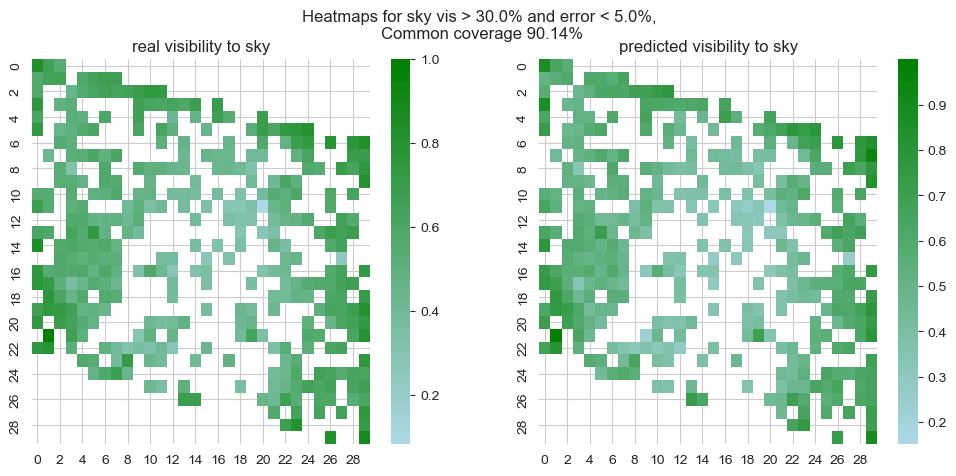

In [27]:
from functools import reduce

from scipy.stats import binned_statistic_2d
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")


pr_percentages = nerf_predictions / 2 + .5

test_df["brick_prediction"] = pr_percentages[:,0]
test_df["brick_presence"] = np.vstack(test_df["f_xyz"].apply(lambda x: list(x.values())))[:,0]

pr_id = 6
pr_class = info_dict["non_empty_classes_names"][pr_id]
test_df[f"{pr_class}_prediction"] = pr_percentages[:,pr_id]
# test_df["metal_prediction"] = np.where(pr_percentages[:,1]>0.05, 100, pr_percentages[:,1])
test_df[f"{pr_class}_presence"] = np.vstack(test_df["f_xyz"].apply(lambda x: list(x.values())))[:,pr_id]

anzlyzed_feature = "brick" ; color="red"#["brick", "metal"]
anzlyzed_feature = pr_class; color="green"
titles = [f'real visibility to {anzlyzed_feature}', f'predicted visibility to {anzlyzed_feature}']
num_bins = 30#100#1000

prediction_heatmap = binned_statistic_2d(test_df['x'], test_df['z']\
                                         , test_df[f"{anzlyzed_feature}_prediction"], statistic='mean', bins=num_bins)[0]
presence_heatmap   = binned_statistic_2d(test_df['x'], test_df['z']\
                                         , test_df[f"{anzlyzed_feature}_presence"], statistic='mean', bins=num_bins)[0]

np.logical_and(presence_heatmap!=0, ~np.isnan(presence_heatmap)).sum() # bins with presence of metal
np.logical_and(prediction_heatmap!=0, ~np.isnan(prediction_heatmap)).sum() # bins with prediction of metal

#conditions
vis_thresold   = 0.3
error_thresold = 0.05
prediction_errors = np.abs(prediction_heatmap-presence_heatmap)
cond_pres = presence_heatmap > vis_thresold   #metal visibility presence larger than x%
# cond_pred = prediction_heatmap > vis_thresold #metal visibility prediction larger than x%
cond_pred = np.logical_and(prediction_heatmap > vis_thresold, prediction_errors < error_thresold) #metal visibility prediction larger than x%


conditions = [cond_pres, cond_pred]
# np.logical_and().sum()

print(reduce(lambda x, y: np.logical_and(x,y), conditions).sum(), cond_pres.sum(), cond_pred.sum()\
, reduce(lambda x, y: np.logical_and(x,y), conditions).sum() / cond_pres.sum())

predicted_coverage = np.logical_and(cond_pres, cond_pred).sum()
real_coverage      = cond_pres.sum()
common_coverage    = np.round(predicted_coverage / real_coverage * 100, 2)
vis_percentage     = np.round(vis_thresold*100, 2)
error_percentage   = np.round(error_thresold*100, 2)


fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap((presence_heatmap.T), cmap=sns.blend_palette(["lightblue", color], as_cmap=True), ax=axes[0])
sns.heatmap((prediction_heatmap.T), cmap=sns.blend_palette(["lightblue", color], as_cmap=True), ax=axes[1])
axes[0].set_title(titles[0]); axes[1].set_title(titles[1])

coverage_stats_title = f"Heatmaps for {anzlyzed_feature} vis > {vis_percentage}% and error < {error_percentage}%"\
                     + f", \nCommon coverage {common_coverage}%\n"
plt.suptitle(coverage_stats_title)
plt.show()


In [49]:
from functools import reduce

from scipy.stats import binned_statistic_2d
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")


pr_percentages = nerf_predictions / 2 + .5

test_df["brick_prediction"] = pr_percentages[:,0]
test_df["metal_prediction"] = pr_percentages[:,1]
# test_df["metal_prediction"] = np.where(pr_percentages[:,1]>0.05, 100, pr_percentages[:,1])

test_df["brick_presence"] = np.vstack(test_df["f_xyz"].apply(lambda x: list(x.values())))[:,0]
test_df["metal_presence"] = np.vstack(test_df["f_xyz"].apply(lambda x: list(x.values())))[:,1]

anzlyzed_feature = "brick" ; color="red"#["brick", "metal"]
# anzlyzed_feature = "metal" ; color="green"
titles = [f'real visibility to {anzlyzed_feature}', f'predicted visibility to {anzlyzed_feature}']
num_bins = 25#100#1000

prediction_heatmap = binned_statistic_2d(test_df['x'], test_df['z']\
                                         , test_df[f"{anzlyzed_feature}_prediction"], statistic='mean', bins=num_bins)[0]
presence_heatmap   = binned_statistic_2d(test_df['x'], test_df['z']\
                                         , test_df[f"{anzlyzed_feature}_presence"], statistic='mean', bins=num_bins)[0]

np.logical_and(presence_heatmap!=0, ~np.isnan(presence_heatmap)).sum() # bins with presence of metal
np.logical_and(prediction_heatmap!=0, ~np.isnan(prediction_heatmap)).sum() # bins with prediction of metal

#conditions
vis_thresold   = 0.2
error_thresold = 0.1
prediction_errors = np.abs(prediction_heatmap-presence_heatmap)
cond_pres = presence_heatmap > vis_thresold   #metal visibility presence larger than x%
# cond_pred = prediction_heatmap > vis_thresold #metal visibility prediction larger than x%
cond_pred = np.logical_and(prediction_heatmap > vis_thresold, prediction_errors < error_thresold) #metal visibility prediction larger than x%


conditions = [cond_pres, cond_pred]
# np.logical_and().sum()

print(reduce(lambda x, y: np.logical_and(x,y), conditions).sum(), cond_pres.sum(), cond_pred.sum()\
, reduce(lambda x, y: np.logical_and(x,y), conditions).sum() / cond_pres.sum())

predicted_coverage = np.logical_and(cond_pres, cond_pred).sum()
real_coverage      = cond_pres.sum()
common_coverage    = np.round(predicted_coverage / real_coverage * 100, 2)
vis_percentage     = np.round(vis_thresold*100, 2)
error_percentage   = np.round(error_thresold*100, 2)


fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap((presence_heatmap.T), cmap=sns.blend_palette(["lightblue", color], as_cmap=True), ax=axes[0])
sns.heatmap((prediction_heatmap.T), cmap=sns.blend_palette(["lightblue", color], as_cmap=True), ax=axes[1])
axes[0].set_title(titles[0]); axes[1].set_title(titles[1])

coverage_stats_title = f"Heatmaps for {anzlyzed_feature} vis > {vis_percentage}% and error < {error_percentage}%"\
                     + f", \nCommon coverage {common_coverage}%\n"
plt.suptitle(coverage_stats_title)
plt.show()


IndexError: index 1 is out of bounds for axis 1 with size 1

In [15]:
test_df.sort_values("metal_presence", ascending=False)

x      y       z   xh     yh  zh  \
3573  1557.3  145.1  1025.3 -2.7  148.0   0   
8573  1573.4  142.3  1207.9 -0.8   48.9   0   
8632  1612.8  144.3  1018.5  0.1  134.9   0   
891   1422.9   96.8  1078.7 -1.1 -102.4   0   
984   1858.6   27.5   514.3 -2.2  145.8   0   
...      ...    ...     ...  ...    ...  ..   
3051    77.9  111.6   789.7  0.0  -37.6   0   
3050    80.7  111.6   794.8 -3.0   83.2   0   
3049    73.1   86.6   797.6 -2.4  -59.1   0   
3048    71.8   86.6   792.7  0.2 -143.0   0   
8739  2213.9  272.4   751.3  1.0 -179.6   0   

                                                  f_xyz  \
3573     {'brick': 0.2619812559, 'metal': 0.4528722913}   
8573   {'brick': 0.28400594005, 'metal': 0.36499800345}   
8632  {'brick': 0.23808268584999998, 'metal': 0.3453...   
891    {'brick': 0.54413157915, 'metal': 0.21904108195}   
984     {'brick': 0.2832803965, 'metal': 0.19980373785}   
...                                                 ...   
3051       {'brick': 0.04882542849999999, 'metal': 0.0}   
3050                       {'brick': 0.0, 'metal': 0.0}   
3049      {'brick': 0.012446465049999966, 'metal': 0.0}   
3048             {'brick': 0.08086939955, 'metal': 0.0}   
8739             {'brick': 0.14006122755, 'metal': 0.0}   

                      image_name        xn        yn  ...  zhn  \
3573  pos1699-1-buildingData-120  0.052212  0.010720  ...    0   
8573  pos1701-1-buildingData-120  0.057566  0.009789  ...    0   
8632  pos1698-0-buildingData-120  0.070670  0.010454  ...    0   
891    pos1832-1-buildingData-70  0.007513 -0.005344  ...    0   
984     pos262-0-buildingData-15  0.152418 -0.028391  ...    0   
...                          ...       ...       ...  ...  ...   
3051    pos482-1-buildingData-70 -0.439807 -0.000421  ...    0   
3050    pos482-0-buildingData-70 -0.438875 -0.000421  ...    0   
3049    pos482-1-buildingData-45 -0.441403 -0.008736  ...    0   
3048    pos482-0-buildingData-45 -0.441835 -0.008736  ...    0   
8739   pos582-1-buildingData-270  0.270583  0.053057  ...    0   

                              f_xyz_raw  residual  steps  \
3573  [100381, 0, 0, 0, 173523, 109257]         0      0   
8573  [108820, 0, 0, 0, 139853, 134488]         0      0   
8632   [91224, 0, 0, 0, 132321, 159616]         0      0   
891     [208490, 0, 0, 0, 83928, 90743]         0      0   
984    [108542, 0, 0, 0, 76557, 198062]         0      0   
...                                 ...       ...    ...   
3051        [18708, 0, 0, 0, 0, 364453]         0      0   
3050            [0, 0, 0, 0, 0, 383161]         0      0   
3049         [4769, 0, 0, 0, 0, 378392]         0      0   
3048        [30986, 0, 0, 0, 0, 352175]         0      0   
8739        [53666, 0, 0, 0, 0, 329495]         0      0   

                   start_locs        start_views  brick_prediction  \
3573  [1557.3, 145.1, 1025.3]   [-2.7, 148.0, 0]          0.411200   
8573  [1573.4, 142.3, 1207.9]    [-0.8, 48.9, 0]          0.456412   
8632  [1612.8, 144.3, 1018.5]    [0.1, 134.9, 0]          0.352643   
891    [1422.9, 96.8, 1078.7]  [-1.1, -102.4, 0]          0.721814   
984     [1858.6, 27.5, 514.3]   [-2.2, 145.8, 0]          0.184148   
...                       ...                ...               ...   
3051     [77.9, 111.6, 789.7]    [0.0, -37.6, 0]          0.079983   
3050     [80.7, 111.6, 794.8]    [-3.0, 83.2, 0]          0.028736   
3049      [73.1, 86.6, 797.6]   [-2.4, -59.1, 0]          0.024188   
3048      [71.8, 86.6, 792.7]   [0.2, -143.0, 0]          0.073056   
8739   [2213.9, 272.4, 751.3]   [1.0, -179.6, 0]          0.148103   

     metal_prediction brick_presence  metal_presence  
3573         0.014123       0.261981        0.452872  
8573         0.025723       0.284006        0.364998  
8632         0.011375       0.238083        0.345340  
891          0.011947       0.544132        0.219041  
984          0.003563       0.283280        0.199804  
...               ...            ...             ...

In [50]:
from functools import reduce

from scipy.stats import binned_statistic_2d
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")


pr_percentages = nerf_predictions / 2 + .5

test_df["brick_prediction"] = pr_percentages[:,0]
test_df["metal_prediction"] = pr_percentages[:,1]
# test_df["metal_prediction"] = np.where(pr_percentages[:,1]>0.05, 100, pr_percentages[:,1])

test_df["brick_presence"] = np.vstack(test_df["f_xyz"].apply(lambda x: list(x.values())))[:,0]
test_df["metal_presence"] = np.vstack(test_df["f_xyz"].apply(lambda x: list(x.values())))[:,1]

anzlyzed_feature = "brick" ; color="red"#["brick", "metal"]
# anzlyzed_feature = "metal" ; color="green"
titles = [f'real visibility to {anzlyzed_feature}', f'predicted visibility to {anzlyzed_feature}']
num_bins = 25#100#1000

prediction_heatmap = binned_statistic_2d(test_df['x'], test_df['z']\
                                         , test_df[f"{anzlyzed_feature}_prediction"], statistic='mean', bins=num_bins)[0]
presence_heatmap   = binned_statistic_2d(test_df['x'], test_df['z']\
                                         , test_df[f"{anzlyzed_feature}_presence"], statistic='mean', bins=num_bins)[0]

np.logical_and(presence_heatmap!=0, ~np.isnan(presence_heatmap)).sum() # bins with presence of metal
np.logical_and(prediction_heatmap!=0, ~np.isnan(prediction_heatmap)).sum() # bins with prediction of metal

#conditions
vis_thresold   = 0.25
error_thresold = 0.1
prediction_errors = np.abs(prediction_heatmap-presence_heatmap)
cond_pres = presence_heatmap > vis_thresold   #metal visibility presence larger than x%
# cond_pred = prediction_heatmap > vis_thresold #metal visibility prediction larger than x%
cond_pred = np.logical_and(prediction_heatmap > vis_thresold, prediction_errors < error_thresold) #metal visibility prediction larger than x%


conditions = [cond_pres, cond_pred]
# np.logical_and().sum()

print(reduce(lambda x, y: np.logical_and(x,y), conditions).sum(), cond_pres.sum(), cond_pred.sum()\
, reduce(lambda x, y: np.logical_and(x,y), conditions).sum() / cond_pres.sum())

predicted_coverage = np.logical_and(cond_pres, cond_pred).sum()
real_coverage      = cond_pres.sum()
common_coverage    = np.round(predicted_coverage / real_coverage * 100, 2)
vis_percentage     = np.round(vis_thresold*100, 2)
error_percentage   = np.round(error_thresold*100, 2)


fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap((presence_heatmap.T), cmap=sns.blend_palette(["lightblue", color], as_cmap=True), ax=axes[0])
sns.heatmap((prediction_heatmap.T), cmap=sns.blend_palette(["lightblue", color], as_cmap=True), ax=axes[1])
axes[0].set_title(titles[0]); axes[1].set_title(titles[1])

coverage_stats_title = f"Heatmaps for {anzlyzed_feature} vis > {vis_percentage}% and error < {error_percentage}%"\
                     + f", \nCommon coverage {common_coverage}%\n"
plt.suptitle(coverage_stats_title)
plt.show()


IndexError: index 1 is out of bounds for axis 1 with size 1

306 376 324 0.8138297872340425


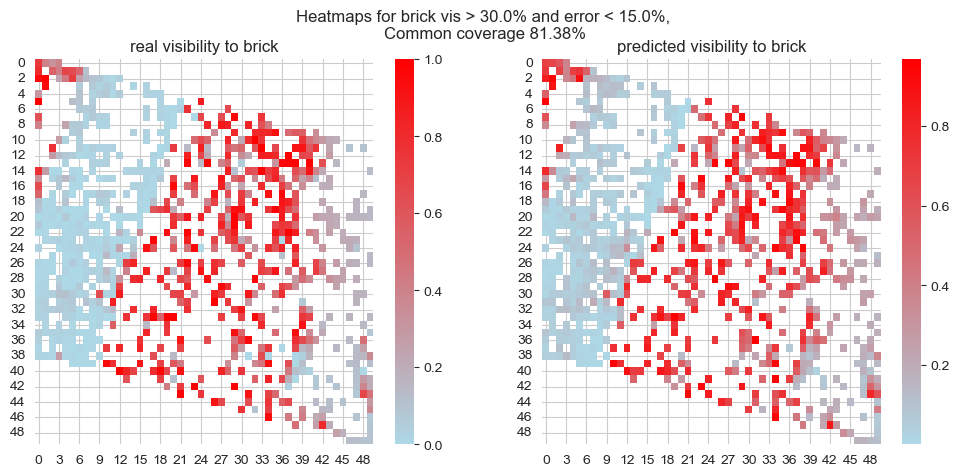

In [572]:
from functools import reduce

anzlyzed_feature = "brick" ; color="red"#["brick", "metal"]
# anzlyzed_feature = "metal" ; color="green"
titles = [f'real visibility to {anzlyzed_feature}', f'predicted visibility to {anzlyzed_feature}']
num_bins = 50#100#1000

prediction_heatmap = binned_statistic_2d(test_df['x'], test_df['z']\
                                         , test_df[f"{anzlyzed_feature}_prediction"], statistic='mean', bins=num_bins)[0]
presence_heatmap   = binned_statistic_2d(test_df['x'], test_df['z']\
                                         , test_df[f"{anzlyzed_feature}_presence"], statistic='mean', bins=num_bins)[0]

np.logical_and(presence_heatmap!=0, ~np.isnan(presence_heatmap)).sum() # bins with presence of metal
np.logical_and(prediction_heatmap!=0, ~np.isnan(prediction_heatmap)).sum() # bins with prediction of metal

#conditions
vis_thresold   = 0.3
error_thresold = 0.15
prediction_errors = np.abs(prediction_heatmap-presence_heatmap)
cond_pres = presence_heatmap > vis_thresold   #metal visibility presence larger than x%
# cond_pred = prediction_heatmap > vis_thresold #metal visibility prediction larger than x%
cond_pred = np.logical_and(prediction_heatmap > vis_thresold, prediction_errors < error_thresold) #metal visibility prediction larger than x%


conditions = [cond_pres, cond_pred]
# np.logical_and().sum()

print(reduce(lambda x, y: np.logical_and(x,y), conditions).sum(), cond_pres.sum(), cond_pred.sum()\
, reduce(lambda x, y: np.logical_and(x,y), conditions).sum() / cond_pres.sum())

predicted_coverage = np.logical_and(cond_pres, cond_pred).sum()
real_coverage      = cond_pres.sum()
common_coverage    = np.round(predicted_coverage / real_coverage * 100, 2)
vis_percentage     = np.round(vis_thresold*100, 2)
error_percentage   = np.round(error_thresold*100, 2)


fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap((presence_heatmap.T), cmap=sns.blend_palette(["lightblue", color], as_cmap=True), ax=axes[0])
sns.heatmap((prediction_heatmap.T), cmap=sns.blend_palette(["lightblue", color], as_cmap=True), ax=axes[1])
axes[0].set_title(titles[0]); axes[1].set_title(titles[1])

coverage_stats_title = f"Heatmaps for {anzlyzed_feature} vis > {vis_percentage}% and error < {error_percentage}%"\
                     + f", \nCommon coverage {common_coverage}%\n"
plt.suptitle(coverage_stats_title)
plt.show()


In [581]:
test_df.sort_values("metal_presence", ascending=False).to_json("test_with_predictions_building_outlier_vanilla_training.json", orient="records", indent=4)

In [579]:
test_df[["brick_prediction", "metal_prediction", "brick_presence", "metal_presence"]].round(4).sort_values("metal_presence", ascending=False).head(20)

brick_prediction  metal_prediction  brick_presence  metal_presence
4932            0.1513            0.2431          0.0000          1.0000
4933            0.4557            0.0709          0.2083          0.7119
4934            0.7156            0.0710          0.2986          0.4351
2478            0.0795            0.2711          0.1659          0.4082
4158            0.2910            0.3743          0.3058          0.3014
1916            0.1332            0.0962          0.1019          0.3006
3726            0.2735            0.2258          0.2685          0.2704
2479            0.2269            0.1302          0.4145          0.2180
2480            0.2942            0.1269          0.4833          0.1459
5294            0.5144            0.0236          0.4726          0.1434
5292            0.3990            0.0332          0.4008          0.1296
5293            0.5950            0.0473          0.2980          0.1080
4873            0.3142            0.0444          0.0841          0.0982
4160            0.5545            0.0516          0.6618          0.0968
1915            0.2428            0.0247          0.0575          0.0948
3727            0.5634            0.0590          0.5591          0.0803
4874            0.3279            0.0402          0.0795          0.0698
4026            0.8620            0.0231          0.7380          0.0601
4339            0.5128            0.0075          0.4940          0.0596
4872            0.1166            0.0141          0.0421          0.0573

In [416]:


np.logical_and(np.isnan(metal_presence_heatmap), np.isnan(metal_prediction_heatmap))#.nan()


np.isnan(metal_presence_heatmap).sum(), np.logical_and(np.isnan(metal_presence_heatmap), np.isnan(metal_prediction_heatmap)).sum()#.sum()
               
               

(1634, 1634)

In [401]:
binned_statistic_2d(test_df['x'], test_df['z'], test_df["metal_prediction"], statistic='mean', bins=num_bins)[0].shape


(50, 50)

In [160]:
pr_percentages[:,0].shape


(5340,)

In [151]:
test_df.shape, len(pr_percentages)

((5340, 22), 5340)

In [154]:
pr_percentages[pr_percentages.argmax(axis=1)==0].tolist()

[[0.8953076004981995, 0.0005328655242919922],
 [0.910071074962616, 2.8908252716064453e-06],
 [0.8702855706214905, 1.2069940567016602e-05],
 [0.46887555718421936, 7.152557373046875e-07],
 [0.688678503036499, 5.066394805908203e-07],
 [0.6918690800666809, 2.682209014892578e-07],
 [0.9605380296707153, 0.00014537572860717773],
 [0.9552249312400818, 8.225440979003906e-06],
 [0.940089225769043, 1.3440847396850586e-05],
 [0.005870521068572998, 0.0],
 [0.00031942129135131836, 0.0],
 [0.014075040817260742, 0.0],
 [0.028907179832458496, 0.0],
 [0.029504835605621338, 0.0],
 [0.029306024312973022, 0.0],
 [0.8105559349060059, 0.0002321302890777588],
 [0.9478648900985718, 0.0003705620765686035],
 [0.8480032682418823, 0.001101464033126831],
 [0.7904897332191467, 1.1026859283447266e-06],
 [0.9057964086532593, 2.5033950805664062e-06],
 [0.8532294034957886, 9.238719940185547e-07],
 [0.6442232131958008, 5.0067901611328125e-06],
 [0.5872647762298584, 2.8908252716064453e-06],
 [0.6066445708274841, 3.4272670

In [145]:
test_df["brick_prediction"] = pr_percentages[pr_percentages.argmax(axis=1)==0]

x          y            z         xh          yh  \
0     1445.512708  44.900160  1172.198293   0.301965  102.279555   
1     1445.512708  44.900160  1172.198293  10.375356   57.255989   
2     1445.512708  44.900160  1172.198293   4.018332   58.343635   
3     2240.637100  12.998301  1949.637011   1.157008   71.819470   
4     2240.637100  12.998301  1949.637011   5.479774   50.662462   
...           ...        ...          ...        ...         ...   
5335    71.883533  52.189190   865.381606  12.294636  -77.102823   
5336    71.883533  52.189190   865.381606  11.316886  -11.820351   
5337   699.980300  42.022900   190.120273   0.379420  170.443827   
5338   699.980300  42.022900   190.120273  16.749432 -176.393466   
5339   699.980300  42.022900   190.120273  10.847574  110.450092   

                zh                                            f_xyz  \
0     2.484843e-17             {'brick': 0.869463243, 'metal': 0.0}   
1     8.083561e-16            {'brick': 0.9537492143, 'metal': 0.0}   
2     7.970982e-16              {'brick': 0.97849374, 'metal': 0.0}   
3     0.000000e+00            {'brick': 0.3792235714, 'metal': 0.0}   
4     3.993946e-16            {'brick': 0.7866142799, 'metal': 0.0}   
...            ...                                              ...   
5335  0.000000e+00    {'brick': 0.037168982849999976, 'metal': 0.0}   
5336  0.000000e+00     {'brick': 0.00626331229999999, 'metal': 0.0}   
5337  6.212157e-18  {'brick': 2.2210499999730793e-06, 'metal': 0.0}   
5338  0.000000e+00                     {'brick': 0.0, 'metal': 0.0}   
5339  0.000000e+00    {'brick': 0.001390366499999962, 'metal': 0.0}   

                     image_name        xn        yn  ...       yhn  \
0     pos1841-0-buildingData-20 -0.012279  0.005120  ...  0.165303   
1     pos1841-1-buildingData-20 -0.012279  0.005120  ...  0.040206   
2     pos1841-2-buildingData-20 -0.012279  0.005120  ...  0.043228   
3     pos1598-0-buildingData-10  0.252716 -0.005512  ...  0.080671   
4     pos1598-1-buildingData-10  0.252716 -0.005512  ...  0.021886   
...                         ...       ...       ...  ...       ...   
5335   pos433-1-buildingData-20 -0.470075  0.007549  ... -0.333106   
5336   pos433-2-buildingData-20 -0.470075  0.007549  ... -0.151720   
5337      pos6-0-buildingData-5 -0.260746  0.004161  ...  0.354695   
5338      pos6-1-buildingData-5 -0.260746  0.004161  ... -0.608982   
5339      pos6-2-buildingData-5 -0.260746  0.004161  ...  0.188005   

               zhn                     f_xyz_raw  residual steps  \
0     1.038308e-19   [391468, 0, 0, 0, 0, 58773]         0     0   
1     2.280783e-18   [429417, 0, 0, 0, 0, 20824]         0     0   
2     2.249503e-18    [440558, 0, 0, 0, 0, 9683]         0     0   
3     3.479019e-20  [170742, 0, 0, 0, 0, 279499]         0     0   
4     1.144496e-18   [354166, 0, 0, 0, 0, 96075]         0     0   
...            ...                           ...       ...   ...   
5335  3.479019e-20   [16735, 0, 0, 0, 0, 433506]         0     0   
5336  3.479019e-20    [2820, 0, 0, 0, 0, 447421]         0     0   
5337  5.205048e-20       [1, 0, 0, 0, 0, 450240]         0     0   
5338  3.479019e-20       [0, 0, 0, 0, 0, 450241]         0     0   
5339  3.479019e-20     [626, 0, 0, 0, 0, 449615]         0     0   

                                             start_locs  \
0     [1445.5127077637, 44.9001598358, 1172.1982933594]   
1     [1445.5127077637, 44.9001598358, 1172.1982933594]   
2     [1445.5127077637, 44.9001598358, 1172.1982933594]   
3     [2240.6371000977, 12.9983010292, 1949.6370109863]   
4     [2240.6371000977, 12.9983010292, 1949.6370109863]   
...                                                 ...   
5335     [71.8835327646, 52.1891899109, 865.3816057617]   
5336     [71.8835327646, 52.1891899109, 865.3816057617]   
5337    [699.9803004639, 42.0228996277, 190.1202728198]   
5338    [699.9803004639, 42.0228996277, 190.1202728198]   
5339    [699.9803004639, 42.0228996277,

In [317]:
for i, lname in  enumerate(logits_dict):
    print(i)

0
1


In [326]:
train_df

x          y            z         xh         yh  \
0      2395.551800  10.000000  1401.722805   3.342201  65.470310   
1      2488.617807  10.000000   726.892208   3.836119  81.653164   
2       450.095855  35.927219  1355.530499   6.458676  16.020453   
3      1220.984694  47.147100  1401.605002   4.031374  45.954467   
4      2246.135098  18.359540  1066.530300   3.451514  71.860115   
...            ...        ...          ...        ...        ...   
20887   428.755340  35.322230  1643.754208   5.108802  11.546651   
20888  1006.165399  43.572250  1572.168606   0.679294  69.012835   
20889  1188.171308  46.826521   857.988393   5.263115  65.132602   
20890  2505.285881  10.000000   624.584600   6.196163  92.888239   
20891   117.942325  48.313290   630.259741  13.732104 -97.753163   

                 zh                                          f_xyz  \
0      5.973700e-16                   {'brick': 0.0, 'metal': 0.0}   
1      0.000000e+00   {'brick': 0.09713020359999996, 'metal': 0.0}   
2      1.000272e-16                   {'brick': 0.0, 'metal': 0.0}   
3      1.992777e-16         {'brick': 0.89078959935, 'metal': 0.0}   
4      0.000000e+00                   {'brick': 1.0, 'metal': 0.0}   
...             ...                                            ...   
20887  0.000000e+00  {'brick': 0.000621889149999999, 'metal': 0.0}   
20888  0.000000e+00    {'brick': 0.6833540259499999, 'metal': 0.0}   
20889  0.000000e+00    {'brick': 0.7580406937499999, 'metal': 0.0}   
20890 -3.999055e-16    {'brick': 0.6127163008500001, 'metal': 0.0}   
20891  0.000000e+00                   {'brick': 0.0, 'metal': 0.0}   

                      image_name        xn        yn  ...           zhn  \
0        pos760-2-buildingData-5  0.335990 -0.006996  ...  1.646898e-18   
1        pos673-2-buildingData-5  0.367000 -0.006996  ... -1.255382e-20   
2      pos1389-2-buildingData-10 -0.312225  0.001643  ...  2.653146e-19   
3      pos1864-2-buildingData-20 -0.055369  0.005381  ...  5.410256e-19   
4       pos764-2-buildingData-15  0.286206 -0.004211  ... -1.255382e-20   
...                          ...       ...       ...  ...           ...   
20887  pos1447-2-buildingData-20 -0.319336  0.001441  ... -1.255382e-20   
20888  pos2139-0-buildingData-20 -0.126946  0.004190  ... -1.255382e-20   
20889  pos1834-2-buildingData-15 -0.066302  0.005274  ... -1.255382e-20   
20890    pos829-1-buildingData-5  0.372553 -0.006996  ... -1.123463e-18   
20891   pos332-1-buildingData-15 -0.422897  0.005770  ...  4.535113e-18   

                          f_xyz_raw  residual  steps  \
0           [0, 0, 0, 0, 0, 450241]         0      0   
1       [43732, 0, 0, 0, 0, 406509]         0      0   
2           [0, 0, 0, 0, 0, 450241]         0      0   
3       [401070, 0, 0, 0, 0, 49171]         0      0   
4           [450241, 0, 0, 0, 0, 0]         0      0   
...                             ...       ...    ...   
20887     [280, 0, 0, 0, 0, 449961]         0      0   
20888  [307674, 0, 0, 0, 0, 142567]         0      0   
20889  [341301, 0, 0, 0, 0, 108940]         0      0   
20890  [275870, 0, 0, 0, 0, 174371]         0      0   
20891       [0, 0, 0, 0, 0, 450241]         0      0   

                                              start_locs  \
0                [2395.551800293, 10.0, 1401.7228049316]   
1                 [2488.6178066406, 10.0, 726.892208252]   
2       [450.0958554688, 35.9272193909, 1355.5304993896]   
3      [1220.9846938477, 47.1471004486, 1401.6050016479]   
4      [2246.1350980225, 18.3595399857, 1066.5303000488]   
...                                                  ...   
20887     [428.755340332, 35.322230339, 1643.7542084961]   
20888  [1006.1653987793, 43.5722503662, 1572.1686062012]   
20889    [1188.1713076172, 46.8265209198, 857.988393457]   
20890            [2505.2858808899, 10.0, 624.5846004883]   
20891    [117.9423248789, 48.3132896423, 630.2597414429]   

                                             start_views  brick_

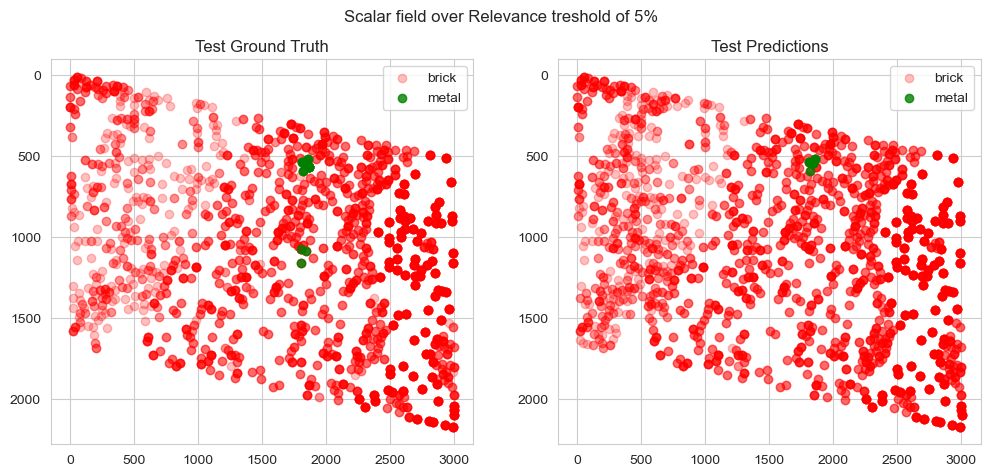

In [380]:
# logits = np.vstack(test_df["f_xyz"].apply(lambda x: list(x.values()))) #ground_truth
# logits = pr_percentages#predictions
df = train_df
logits_dict = {
     "Train Ground Truth" : np.vstack(train_df["f_xyz"].apply(lambda x: list(x.values())))
    , "Train Predictions" : train_nerf_predictions * 0.5 + 0.5
              }

df = test_df
logits_dict = {
    "Test Ground Truth" : np.vstack(test_df["f_xyz"].apply(lambda x: list(x.values())))
    , "Test Predictions" : nerf_predictions * 0.5 + 0.5
}


fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for i, lname in  enumerate(logits_dict):

    logits = logits_dict[lname]
    relevance_threshold = 0.05
    # brick_locations = df[["x", "z"]].values[(logits.argmax(axis=1) == 0) & (logits[:,0]>relevance_threshold)]
    # metal_locations = df[["x", "z"]].values[(logits.argmax(axis=1) == 1) & (logits[:,1]>relevance_threshold)]
    brick_locations = df[["x", "z"]].values[(logits[:,0]>relevance_threshold)]
    metal_locations = df[["x", "z"]].values[(logits[:,1]>relevance_threshold)]


    # brick_locations = vdf[["x", "z"]].values[np.vstack(test_df["f_xyz"].values)[:,:2].argmax(axis=1) == 0]


    # yellow_locations = vdf[["x", "z"]].values[np.vstack(vdf["f_xyz_raw"].values)[:,:4].argmax(axis=1) == 3]

    import matplotlib.pyplot as plt

    # plt.scatter(vdf["x"], vdf["z"])


#     fig, ax = plt.subplots()
    ax = axes[i]
    ax.invert_yaxis()
    # ax.invert_xaxis()
    ax.scatter(brick_locations[:,0], brick_locations[:,1], color="red", label="brick", alpha=.25)
    ax.scatter(metal_locations[:,0], metal_locations[:,1], color="green", label="metal",  alpha=.8)
    # plt.scatter(yellow_locations[:,0], yellow_locations[:,1], color="yellow", label="yellow",  alpha=.8)

    ax.legend()
    ax.set_title(f"{lname}")

plt.suptitle(f"Scalar field over Relevance treshold of {int(relevance_threshold * 100)}%")
plt.show()

In [390]:
train_df["predicted_f"] = train_df.apply(lambda x: {"brick" : x["brick_prediction"]\
                                                   , "metal" : x["metal_prediction"]}, axis=1)
# print(train_df[["x","z","f_xyz", "predicted_f"]].head(2).to_json(indent=4, orient="records"))
train_df[["x","z","f_xyz", "predicted_f"]].to_json("../d3_charts/scatter_comparison/train.json", indent=4, orient="records")


test_df["predicted_f"] = test_df.apply(lambda x: {"brick" : x["brick_prediction"]\
                                                   , "metal" : x["metal_prediction"]}, axis=1)
test_df[["x","z","f_xyz", "predicted_f"]].to_json("../d3_charts/scatter_comparison/test.json", indent=4, orient="records")


In [387]:
print(train_df[["x","z","f_xyz"]].head(2).to_json(indent=4, orient="records"))

[
    {
        "x":2395.551800293,
        "z":1401.7228049316,
        "f_xyz":{
            "brick":0.0,
            "metal":0.0
        }
    },
    {
        "x":2488.6178066406,
        "z":726.892208252,
        "f_xyz":{
            "brick":0.0971302036,
            "metal":0.0
        }
    }
]


In [386]:
print(train_df[["x","z","f_xyz"]].head(2).to_json(indent=4, orient="records"))

[
    {
        "x":2395.551800293,
        "y":10.0,
        "z":1401.7228049316,
        "xh":3.3422012158,
        "yh":65.4703095385,
        "zh":5.973700414e-16,
        "f_xyz":{
            "brick":0.0,
            "metal":0.0
        },
        "image_name":"pos760-2-buildingData-5",
        "xn":0.335990475,
        "yn":-0.0069959335,
        "zn":0.1150863937,
        "xhn":-0.0094878582,
        "yhn":0.0699732111,
        "zhn":1.646897863e-18,
        "f_xyz_raw":[
            0,
            0,
            0,
            0,
            0,
            450241
        ],
        "residual":0,
        "steps":0,
        "start_locs":[
            2395.551800293,
            10.0,
            1401.7228049316
        ],
        "start_views":[
            3.3422012158,
            65.4703095385,
            5.973700414e-16
        ],
        "brick_prediction":0.1462984979,
        "metal_prediction":0.0000106096,
        "brick_presence":0.0,
        "metal_presence":0.0
    

In [39]:
test_df

x          y            z         xh          yh  \
0     1445.512708  44.900160  1172.198293   0.301965  102.279555   
1     1445.512708  44.900160  1172.198293  10.375356   57.255989   
2     1445.512708  44.900160  1172.198293   4.018332   58.343635   
3     2240.637100  12.998301  1949.637011   1.157008   71.819470   
4     2240.637100  12.998301  1949.637011   5.479774   50.662462   
...           ...        ...          ...        ...         ...   
5335    71.883533  52.189190   865.381606  12.294636  -77.102823   
5336    71.883533  52.189190   865.381606  11.316886  -11.820351   
5337   699.980300  42.022900   190.120273   0.379420  170.443827   
5338   699.980300  42.022900   190.120273  16.749432 -176.393466   
5339   699.980300  42.022900   190.120273  10.847574  110.450092   

                zh                                            f_xyz  \
0     2.484843e-17             {'brick': 0.869463243, 'metal': 0.0}   
1     8.083561e-16            {'brick': 0.9537492143, 'metal': 0.0}   
2     7.970982e-16              {'brick': 0.97849374, 'metal': 0.0}   
3     0.000000e+00            {'brick': 0.3792235714, 'metal': 0.0}   
4     3.993946e-16            {'brick': 0.7866142799, 'metal': 0.0}   
...            ...                                              ...   
5335  0.000000e+00    {'brick': 0.037168982849999976, 'metal': 0.0}   
5336  0.000000e+00     {'brick': 0.00626331229999999, 'metal': 0.0}   
5337  6.212157e-18  {'brick': 2.2210499999730793e-06, 'metal': 0.0}   
5338  0.000000e+00                     {'brick': 0.0, 'metal': 0.0}   
5339  0.000000e+00    {'brick': 0.001390366499999962, 'metal': 0.0}   

                     image_name        xn        yn  ...       yhn  \
0     pos1841-0-buildingData-20 -0.012279  0.005120  ...  0.165303   
1     pos1841-1-buildingData-20 -0.012279  0.005120  ...  0.040206   
2     pos1841-2-buildingData-20 -0.012279  0.005120  ...  0.043228   
3     pos1598-0-buildingData-10  0.252716 -0.005512  ...  0.080671   
4     pos1598-1-buildingData-10  0.252716 -0.005512  ...  0.021886   
...                         ...       ...       ...  ...       ...   
5335   pos433-1-buildingData-20 -0.470075  0.007549  ... -0.333106   
5336   pos433-2-buildingData-20 -0.470075  0.007549  ... -0.151720   
5337      pos6-0-buildingData-5 -0.260746  0.004161  ...  0.354695   
5338      pos6-1-buildingData-5 -0.260746  0.004161  ... -0.608982   
5339      pos6-2-buildingData-5 -0.260746  0.004161  ...  0.188005   

               zhn                     f_xyz_raw  residual steps  \
0     1.038308e-19   [391468, 0, 0, 0, 0, 58773]         0     0   
1     2.280783e-18   [429417, 0, 0, 0, 0, 20824]         0     0   
2     2.249503e-18    [440558, 0, 0, 0, 0, 9683]         0     0   
3     3.479019e-20  [170742, 0, 0, 0, 0, 279499]         0     0   
4     1.144496e-18   [354166, 0, 0, 0, 0, 96075]         0     0   
...            ...                           ...       ...   ...   
5335  3.479019e-20   [16735, 0, 0, 0, 0, 433506]         0     0   
5336  3.479019e-20    [2820, 0, 0, 0, 0, 447421]         0     0   
5337  5.205048e-20       [1, 0, 0, 0, 0, 450240]         0     0   
5338  3.479019e-20       [0, 0, 0, 0, 0, 450241]         0     0   
5339  3.479019e-20     [626, 0, 0, 0, 0, 449615]         0     0   

                                             start_locs  \
0     [1445.5127077637, 44.9001598358, 1172.1982933594]   
1     [1445.5127077637, 44.9001598358, 1172.1982933594]   
2     [1445.5127077637, 44.9001598358, 1172.1982933594]   
3     [2240.6371000977, 12.9983010292, 1949.6370109863]   
4     [2240.6371000977, 12.9983010292, 1949.6370109863]   
...                                                 ...   
5335     [71.8835327646, 52.1891899109, 865.3816057617]   
5336     [71.8835327646, 52.1891899109, 865.3816057617]   
5337    [699.9803004639, 42.0228996277, 190.1202728198]   
5338    [699.9803004639, 42.0228996277, 190.1202728198]   
5339    [699.9803004639, 42.0228996277,

In [30]:
pr_percentages[pr_percentages[:,1].argsort()[::-1]]

array([[0.29104275, 0.37427092],
       [0.07948473, 0.27107382],
       [0.15130582, 0.24305606],
       [0.2734791 , 0.22579533],
       [0.22694033, 0.13018924],
       [0.29418898, 0.12693167],
       [0.78287876, 0.10548556],
       [0.1332038 , 0.09621871],
       [0.5084795 , 0.08406401],
       [0.71559787, 0.07100332],
       [0.45573032, 0.07085943],
       [0.5633679 , 0.05899754],
       [0.5545377 , 0.05163011],
       [0.98081183, 0.0476405 ],
       [0.59497297, 0.04727858],
       [0.3257245 , 0.04658413],
       [0.299776  , 0.04586574],
       [0.31421643, 0.04437628],
       [0.32794952, 0.04020369],
       [0.39901447, 0.03321657],
       [0.29019174, 0.02635098],
       [0.24276823, 0.02474388],
       [0.51440716, 0.02358007],
       [0.861982  , 0.02310866],
       [0.46027187, 0.01468354],
       [0.36795837, 0.01437739],
       [0.6054074 , 0.01426527],
       [0.11664599, 0.01405647],
       [0.30644375, 0.01378652],
       [0.68416613, 0.01338091],
       [0.

In [24]:
pr_percentages.max(axis=0), pr_percentages.mean(axis=0), \
(pr_percentages/pr_percentages.max(axis=0)).max(axis=0)

(array([0.9959263 , 0.37427092], dtype=float32),
 array([0.32268223, 0.00061676], dtype=float32),
 array([1., 1.], dtype=float32))

# Clustering + PCA

In [17]:
import umap
import seaborn as sns
import matplotlib.pyplot as plt


pr_percentages = nerf_predictions / 2 + .5
# pr_percentages = test_df[projector_name] / 2 + 5
# predicition_dev = np.where(nerf_predictions<-.99, -np.inf, nerf_predictions) / pr_percentages.mean(axis=0)
predicition_dev = np.where(nerf_predictions<-.99, -np.inf, nerf_predictions) / pr_percentages.max(axis=0)
# pr_colors      = (predicition_dev).argmax(axis=1)
pr_colors      = (pr_percentages).argmax(axis=1)
categories     = np.take(["brick", "metal"], pr_colors)#pr_colors #index of colors for each predicition.
X = pr_percentages




from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
import numpy as np

clustering_paramters = {"Gaussian Mixture":2,"Agglomerative":10,"DBSCAN":5}
label_clustering = {"Gaussian Mixture": GaussianMixture(n_components=clustering_paramters["Gaussian Mixture"], covariance_type='full', random_state=42),
                    "Agglomerative": AgglomerativeClustering(n_clusters=clustering_paramters["Agglomerative"], linkage='ward'),
                   "DBSCAN": DBSCAN(eps=0.5, min_samples=clustering_paramters["DBSCAN"])}



for lcm in label_clustering:
    clusterer = label_clustering[lcm]
    
    labels = clusterer.fit_predict(X).reshape(-1, 1)#label_clustering[lcm]

    # Visualize using PCA/t-SNE/UMAP
    # Reduce dimensions to 2D using UMAP
    reducer = umap.UMAP(n_components=2, random_state=42)
    X_umap = reducer.fit_transform(labels)

    # Scatter plot
    plt.figure(figsize=(8,6))
    # sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=categories, palette=["red", "green"], alpha=.7)


    brick_locations = X_umap[categories=="brick"]
    metal_locations = X_umap[categories=="metal"]
    plt.scatter(brick_locations[:,0], brick_locations[:,1], color="red", label="brick", alpha=.05)
    plt.scatter(metal_locations[:,0], metal_locations[:,1], color="green", label="metal",  alpha=.9)


    plt.legend()
    plt.title(f"{lcm} - {clustering_paramters[lcm]} - Clusters \nprojected with UMAP")
    plt.show()

IndexError: index 2 is out of bounds for axis 0 with size 2

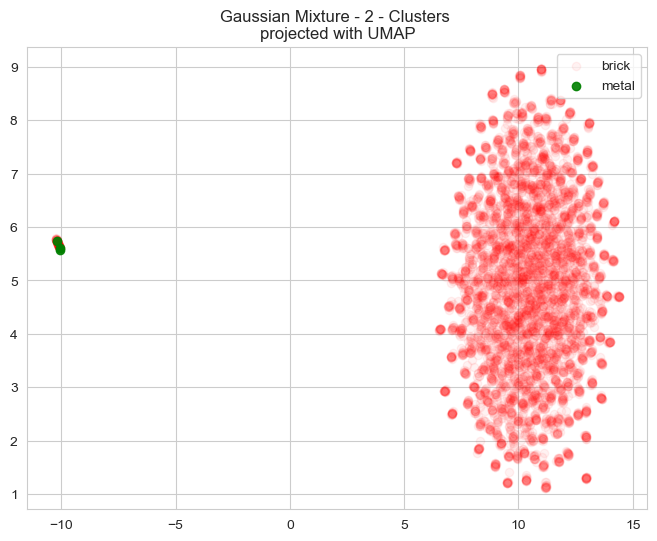

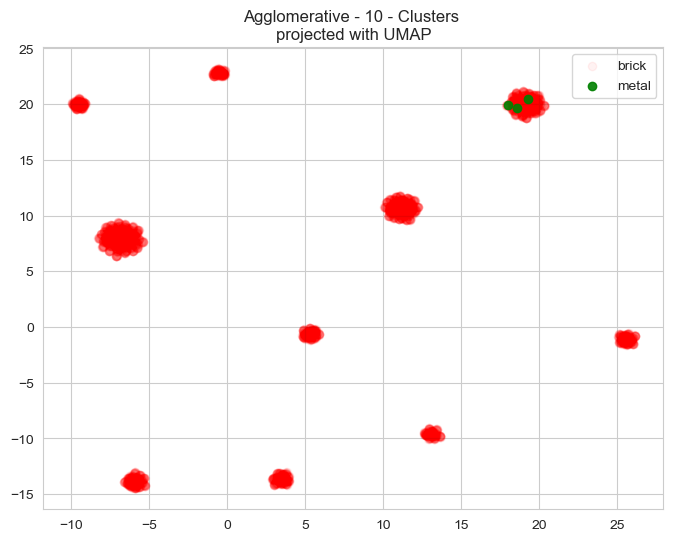

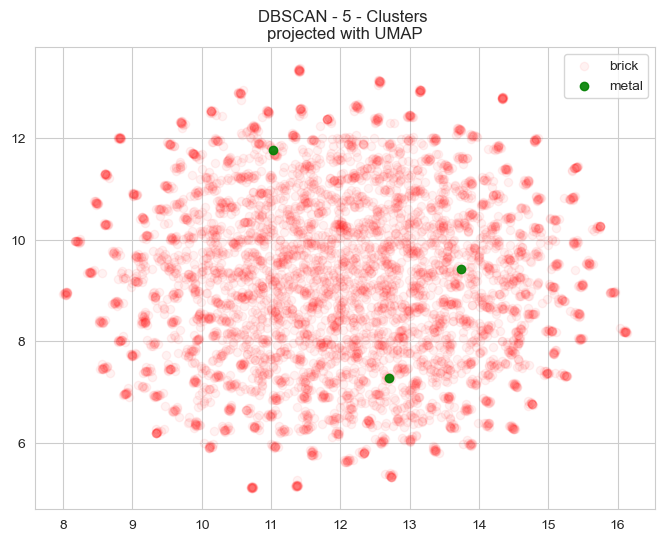

In [137]:
import umap
import seaborn as sns
import matplotlib.pyplot as plt


pr_percentages = nerf_predictions / 2 + .5
# pr_percentages = test_df[projector_name] / 2 + 5
# predicition_dev = np.where(nerf_predictions<-.99, -np.inf, nerf_predictions) / pr_percentages.mean(axis=0)
predicition_dev = np.where(nerf_predictions<-.99, -np.inf, nerf_predictions) / pr_percentages.max(axis=0)
# pr_colors      = (predicition_dev).argmax(axis=1)
pr_colors      = (pr_percentages).argmax(axis=1)
categories     = np.take(["brick", "metal"], pr_colors)#pr_colors #index of colors for each predicition.
X = pr_percentages




from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
import numpy as np

clustering_paramters = {"Gaussian Mixture":2,"Agglomerative":10,"DBSCAN":5}
label_clustering = {"Gaussian Mixture": GaussianMixture(n_components=clustering_paramters["Gaussian Mixture"], covariance_type='full', random_state=42),
                    "Agglomerative": AgglomerativeClustering(n_clusters=clustering_paramters["Agglomerative"], linkage='ward'),
                   "DBSCAN": DBSCAN(eps=0.5, min_samples=clustering_paramters["DBSCAN"])}



for lcm in label_clustering:
    clusterer = label_clustering[lcm]
    
    labels = clusterer.fit_predict(X).reshape(-1, 1)#label_clustering[lcm]

    # Visualize using PCA/t-SNE/UMAP
    # Reduce dimensions to 2D using UMAP
    reducer = umap.UMAP(n_components=2, random_state=42)
    X_umap = reducer.fit_transform(labels)

    # Scatter plot
    plt.figure(figsize=(8,6))
    # sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=categories, palette=["red", "green"], alpha=.7)


    brick_locations = X_umap[categories=="brick"]
    metal_locations = X_umap[categories=="metal"]
    plt.scatter(brick_locations[:,0], brick_locations[:,1], color="red", label="brick", alpha=.05)
    plt.scatter(metal_locations[:,0], metal_locations[:,1], color="green", label="metal",  alpha=.9)


    plt.legend()
    plt.title(f"{lcm} - {clustering_paramters[lcm]} - Clusters \nprojected with UMAP")
    plt.show()

In [135]:
GaussianMixture(n_components=10, covariance_type='full', random_state=42).n_components

10

In [133]:
AgglomerativeClustering(n_clusters=10, linkage='ward').n_clusters

10

K-Means + PCA

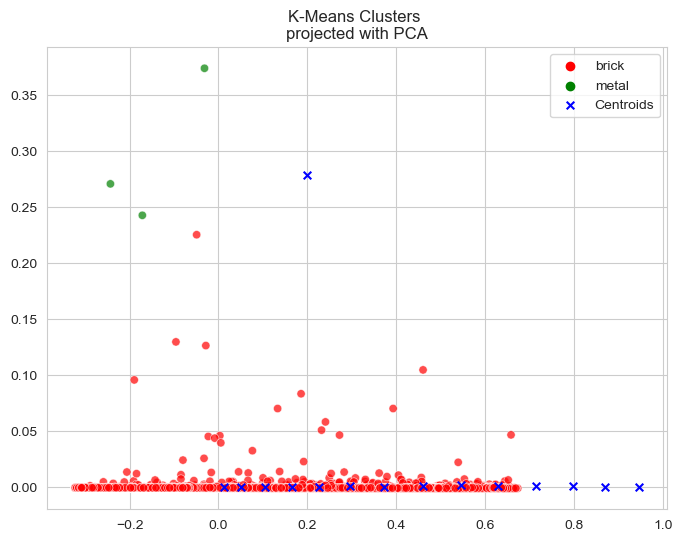

In [129]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

# Generate random n-dimensional data (replace with your dataset)
np.random.seed(42)
n_samples = 3000
n_features = 50  # Adjust this based on your actual data
# X = np.random.rand(n_samples, n_features)


pr_percentages = nerf_predictions / 2 + .5
# pr_percentages = test_df[projector_name] / 2 + 5
# predicition_dev = np.where(nerf_predictions<-.99, -np.inf, nerf_predictions) / pr_percentages.mean(axis=0)
predicition_dev = np.where(nerf_predictions<-.99, -np.inf, nerf_predictions) / pr_percentages.max(axis=0)
# pr_colors      = (predicition_dev).argmax(axis=1)
pr_colors      = (pr_percentages).argmax(axis=1)
categories     = np.take(["brick", "metal"], pr_colors)#pr_colors #index of colors for each predicition.
X = pr_percentages

# Apply K-Means clustering
k = 15  # Choose the number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(X)

# Reduce to 2D using PCA or t-SNE
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Alternative: Use t-SNE
# tsne = TSNE(n_components=2, perplexity=30, random_state=42)
# X_tsne = tsne.fit_transform(X)

# Plot clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=categories, palette=["red", "green"], alpha=.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c="blue", marker="x", s=30, label="Centroids")
# plt.title("Projected n-dim clusters")
plt.title(f"K-Means Clusters \nprojected with PCA")
plt.legend()
plt.show()

# Simplemented UMAP and PCA


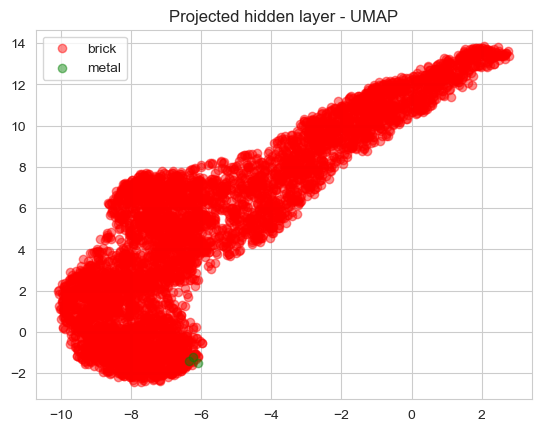

In [101]:

from sklearn.decomposition import PCA
import umap
from sklearn.manifold import TSNE

# data_path           = "./utils/assets/data/splits_physical/test_set_4800.json"
# trained_model_path  = "./utils/assets/data/splits_physical/models/encoder_100.pt"

# data_path          = "./utils/assets/data/perception_metrics/test_set_4800.json"
# trained_model_path = "./utils/assets/data/perception_metrics/models/encoder_350.pt"


# nerf_predictions, nerf_latent_features, test_df = \
# get_hidden_layer_predictions(data_path, trained_model_path, frac=1)
# 

# 2. Projectors
# PCA transformation
# projector = PCA(n_components=2)
# t-SNE transformation
# projector = TSNE(init='pca', learning_rate='auto', n_components=2, perplexity=30, n_iter=300)
# UMAP transformation
# projector = umap.UMAP(n_components=2, n_neighbors=15)


# nerf_predictions, nerf_latent_features, test_df, trained_encoder

#3. categories:
#predicted colors
projector_name = "UMAP"
# projector_name = "PCA"

pr_percentages = nerf_predictions / 2 + .5
# pr_percentages = test_df[projector_name] / 2 + 5
# predicition_dev = np.where(nerf_predictions<-.99, -np.inf, nerf_predictions) / pr_percentages.mean(axis=0)
predicition_dev = np.where(nerf_predictions<-.99, -np.inf, nerf_predictions) / pr_percentages.max(axis=0)

# pr_colors      = (predicition_dev).argmax(axis=1)
pr_colors      = (pr_percentages).argmax(axis=1)
categories     = pr_colors #index of colors for each predicition.
# categories = None #For uniform colors

#4. Category names
# category_names = ['building', ' water', 'tree', 'sky']# semantics #[' building' ' water' ' road ' ' sidewalk' ' surface' ' tree' ' sky']
# colors = ["darkslategrey", "navy", "forestgreen", "deepskyblue"]
# category_names = ["greenness", "openness", "imageability", "encolusre", "walkability", "serenity"] #perception metrics
# colors = None# ["forestgreen", "deepskyblue", "fuchsia", "darkslategrey", "darkgoldenrod", "navy"]

# Final Semantics:
# category_names      = ['building', 'water', 'road ', 'sidewalk', 'surface', 'tree', 'sky', 'miscellaneous']
# colors              = ["#ffffe5", "#e5f5f9", "#ccece6", "#99d8c9", "#66c2a4", "#41ae76", "#238b45", "#005824"]# https://colorbrewer2.org/#type=sequential&scheme=BuGn&n=8
# colors              = ["#762a83", "#9970ab", "#c2a5cf", "#e7d4e8", "#d9f0d3", "#a6dba0", "#5aae61", "#1b7837"]# https://colorbrewer2.org/#type=sequential&scheme=BuGn&n=8

colors = sns.color_palette("tab10")
colors = ["red", "green"]
# category_names      = ['brick','concrete','marble' ,'plaster','metal','nothing']
category_names      = ['brick','metal']

category_names

for i, category in enumerate(np.arange(len(category_names))):
    projected_results_x = np.vstack(test_df[projector_name])[categories == category, 0]
    projected_results_y = np.vstack(test_df[projector_name])[categories == category, 1]
    
    plt.scatter(projected_results_x, projected_results_y, 
                color=colors[i], label=f'{category_names[category]}', alpha=.45)
    plt.legend()


#5. Hexbin or density plot
# hexbin = False; density_plot=False
# hexbin = True; density_plot=False
plt.title("Projected hidden layer - UMAP")
plt.show()

# project_data_on_2d_plot(nerf_latent_features, projector, categories, category_names, colors, density_plot, hexbin)

# nerf_latent_features = test_df[projector_name].tolist()

# projector, projections = project_data_on_2d_plot(nerf_latent_features, projector, categories, category_names, colors, density_plot=density_plot, hexbin=hexbin, )


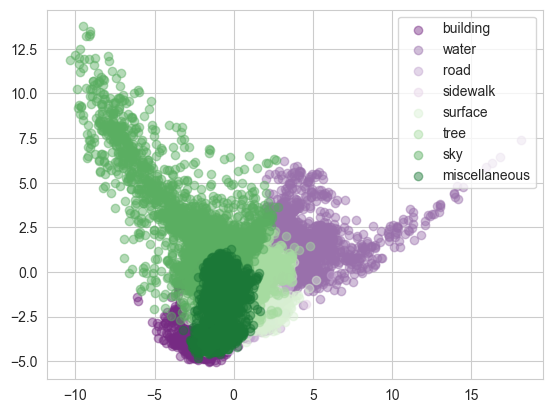

In [55]:

from sklearn.decomposition import PCA
import umap
from sklearn.manifold import TSNE

# data_path           = "./utils/assets/data/splits_physical/test_set_4800.json"
# trained_model_path  = "./utils/assets/data/splits_physical/models/encoder_100.pt"

# data_path          = "./utils/assets/data/perception_metrics/test_set_4800.json"
# trained_model_path = "./utils/assets/data/perception_metrics/models/encoder_350.pt"


# nerf_predictions, nerf_latent_features, test_df = \
# get_hidden_layer_predictions(data_path, trained_model_path, frac=1)
# 

# 2. Projectors
# PCA transformation
# projector = PCA(n_components=2)
# t-SNE transformation
# projector = TSNE(init='pca', learning_rate='auto', n_components=2, perplexity=30, n_iter=300)
# UMAP transformation
# projector = umap.UMAP(n_components=2, n_neighbors=15)


# nerf_predictions, nerf_latent_features, test_df, trained_encoder

#3. categories:
#predicted colors
# projector_name = "UMAP"
projector_name = "PCA"

pr_percentages = nerf_predictions / 2 + .5
# pr_percentages = test_df[projector_name] / 2 + 5
pr_colors      = (pr_percentages / pr_percentages.mean(axis=0)).argmax(axis=1)
categories     = pr_colors #index of colors for each predicition.
# categories = None #For uniform colors

#4. Category names
# category_names = ['building', ' water', 'tree', 'sky']# semantics #[' building' ' water' ' road ' ' sidewalk' ' surface' ' tree' ' sky']
# colors = ["darkslategrey", "navy", "forestgreen", "deepskyblue"]
# category_names = ["greenness", "openness", "imageability", "encolusre", "walkability", "serenity"] #perception metrics
# colors = None# ["forestgreen", "deepskyblue", "fuchsia", "darkslategrey", "darkgoldenrod", "navy"]

# Final Semantics:
category_names      = ['building', 'water', 'road ', 'sidewalk', 'surface', 'tree', 'sky', 'miscellaneous']
# colors              = ["#ffffe5", "#e5f5f9", "#ccece6", "#99d8c9", "#66c2a4", "#41ae76", "#238b45", "#005824"]# https://colorbrewer2.org/#type=sequential&scheme=BuGn&n=8
colors              = ["#762a83", "#9970ab", "#c2a5cf", "#e7d4e8", "#d9f0d3", "#a6dba0", "#5aae61", "#1b7837"]# https://colorbrewer2.org/#type=sequential&scheme=BuGn&n=8

category_names

for i, category in enumerate(np.arange(len(category_names))):
    projected_results_x = np.vstack(test_df[projector_name])[categories == category, 0]
    projected_results_y = np.vstack(test_df[projector_name])[categories == category, 1]
    
    plt.scatter(projected_results_x, projected_results_y, 
                color=colors[i], label=f'{category_names[category]}', alpha=.45)
    plt.legend()


#5. Hexbin or density plot
# hexbin = False; density_plot=False
# hexbin = True; density_plot=False



# project_data_on_2d_plot(nerf_latent_features, projector, categories, category_names, colors, density_plot, hexbin)

# nerf_latent_features = test_df[projector_name].tolist()

# projector, projections = project_data_on_2d_plot(nerf_latent_features, projector, categories, category_names, colors, density_plot=density_plot, hexbin=hexbin, )


In [52]:
np.vstack(test_df[projector_name])

array([[ 3.82865024,  7.27693987],
       [ 3.82952881,  7.54442787],
       [ 3.87457371,  7.32597971],
       [ 3.51008582,  7.16940975],
       [ 3.33755445,  7.1602149 ],
       [ 3.40131259,  7.22117662],
       [ 7.26513386, -1.39192247],
       [ 6.22490168,  1.09551704],
       [ 7.89843035,  0.25878841],
       [ 7.83857632, -0.12530157],
       [ 7.85753059, -0.12465407],
       [ 7.79972601, -0.08214557],
       [ 5.17122507,  4.23174858],
       [ 4.97715187,  5.27309752],
       [ 5.45890522,  5.07988453],
       [ 5.39898252,  4.90789747],
       [ 5.81167173,  5.20958996],
       [ 5.88810205,  5.23231554],
       [ 3.20174718,  2.28013754],
       [ 2.73569274,  1.97602105],
       [ 2.73583674,  1.97566569],
       [ 3.07995391,  2.23128581],
       [ 2.82737255,  1.98274672],
       [ 2.74894118,  2.00414658],
       [ 9.53786182, -3.12253523],
       [14.44959068,  6.58264017],
       [15.75377369,  0.80546039],
       [11.94317245,  1.88083291],
       [12.5453825 ,

In [48]:
test_df[projector_name]

0        [3.8286502361297607, 7.276939868927002]
1          [3.82952880859375, 7.544427871704102]
2        [3.8745737075805664, 7.325979709625244]
3         [3.5100858211517334, 7.16940975189209]
4         [3.337554454803467, 7.160214900970459]
                          ...                   
14995      [16.78374671936035, 6.83135986328125]
14996    [16.306201934814453, 2.822352170944214]
14997    [11.960247993469238, 2.500530481338501]
14998    [12.664933204650879, 5.683242321014404]
14999    [13.554556846618652, 5.999382495880127]
Name: UMAP, Length: 15000, dtype: object

In [28]:
pr_colors

np.unique(categories)

array([0, 1, 2, 4, 5, 6, 7])

In [147]:
train_preds, train_nlf, _ = get_hidden_layer_predictions("./utils/assets/data/perception_metrics/train_set_100-percent.json"\
                                               , trained_model_path, frac=.05)


print(category_names)

['greenness', 'openness', 'imageability', 'encolusre', 'walkability', 'serenity']


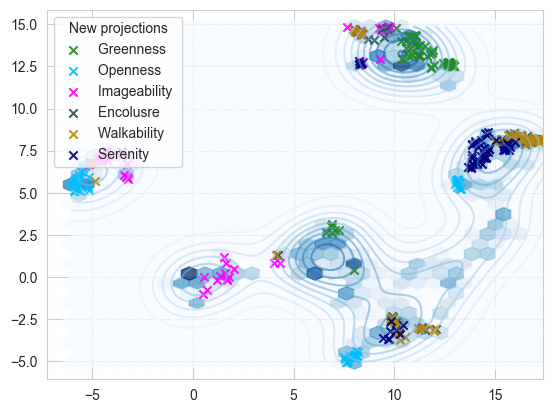

In [155]:
# selected_category = "encolusre"

from scipy.stats import gaussian_kde
x, y = projections[:, 0], projections[:, 1]
k = gaussian_kde([x, y])
xi, yi = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
plt.contour(xi, yi, zi.reshape(xi.shape), levels=10, cmap="Blues", alpha=0.5)

plt.hexbin(projections[:, 0], projections[:, 1], gridsize=30, cmap='Blues', alpha=0.75)


colors = ["forestgreen", "deepskyblue", "fuchsia", "darkslategrey", "darkgoldenrod", "navy"]

for i, selected_category in enumerate(category_names):
    percentile        = 95

    sc_id             = category_names.index(selected_category)
    selected_ids      = train_preds[:, sc_id] > np.percentile(train_preds[:, sc_id], percentile)
    new_projections   = projector.transform(train_nlf[selected_ids])





    plt.scatter(new_projections[:,0], new_projections[:, 1], marker="x", 
            color=colors[i], label=f'{selected_category.capitalize()} ', alpha=.9)

    plt.legend(title="New projections", loc=2)
plt.show()

In [10]:
projector, projections

(PCA(n_components=2),
 array([[ 2.2633393, -1.2436522],
        [ 1.3273396, -2.073902 ],
        [ 1.1519569, -1.7944285],
        ...,
        [ 1.291452 ,  1.6869233],
        [ 3.4978945, -1.64791  ],
        [ 0.9676355, -2.4871519]], dtype=float32))

In [71]:
train_preds, train_nlf, _ = get_hidden_layer_predictions("./utils/assets/data/perception_metrics/train_set_100-percent.json"\
                                               , trained_model_path, frac=.05)


Surface not initialized properly. Can only predict from raw position and direction.
Succesful model intialization and data loading.
Predicting hidden layers...


  0%|          | 0/1071 [00:00<?, ?it/s]

Succesfully inferred hidden layer values for provided test set.


In [72]:
np.percentile(train_preds[:, 2], 95), np.median(train_preds[:, 2]), train_preds.argmax(axis=1)#.mean()

(-0.9508863389492035, -0.9929199, array([0, 0, 0, ..., 5, 0, 0]))

In [157]:
print(category_names)

['greenness', 'openness', 'imageability', 'encolusre', 'walkability', 'serenity']


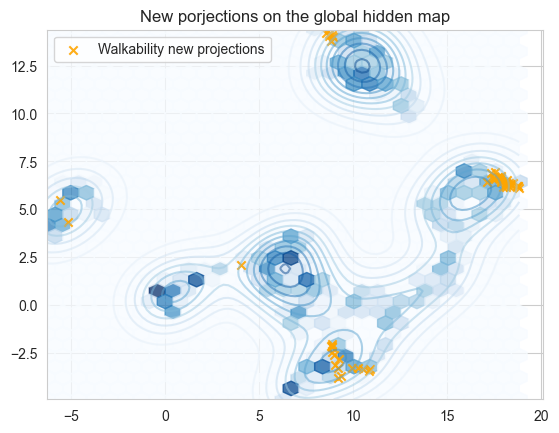

In [172]:
selected_category = "walkability"
percentile        = 95

sc_id             = category_names.index(selected_category)
selected_ids      = train_preds[:, sc_id] > np.percentile(train_preds[:, sc_id], percentile)
new_projections   = projector.transform(train_nlf[selected_ids])



from scipy.stats import gaussian_kde
x, y = projections[:, 0], projections[:, 1]
k = gaussian_kde([x, y])
xi, yi = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
plt.contour(xi, yi, zi.reshape(xi.shape), levels=10, cmap="Blues", alpha=0.5)

plt.hexbin(projections[:, 0], projections[:, 1], gridsize=30, cmap='Blues', alpha=0.75)


plt.scatter(new_projections[:,0], new_projections[:, 1], marker="x", 
                        color="orange", label=f'{selected_category.capitalize()} new projections', alpha=.9)

plt.legend(loc=2)
plt.title("New porjections on the global hidden map")
plt.show()

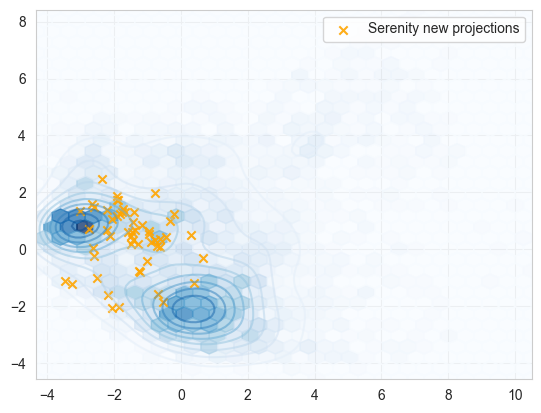

In [85]:
selected_category = "serenity"
percentile        = 95

sc_id             = category_names.index(selected_category)
selected_ids      = train_preds[:, sc_id] > np.percentile(train_preds[:, sc_id], percentile)
new_projections   = projector.transform(train_nlf[selected_ids])



from scipy.stats import gaussian_kde
x, y = projections[:, 0], projections[:, 1]
k = gaussian_kde([x, y])
xi, yi = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
plt.contour(xi, yi, zi.reshape(xi.shape), levels=10, cmap="Blues", alpha=0.5)

plt.hexbin(projections[:, 0], projections[:, 1], gridsize=30, cmap='Blues', alpha=0.75)


plt.scatter(new_projections[:,0], new_projections[:, 1], marker="x", 
                        color="orange", label=f'{selected_category.capitalize()} new projections', alpha=.9)

plt.legend()
plt.show()

# Initial Experiments & Development Drafts

In [1]:
from utils.scripts.architectures.train_location_encoder \
import get_location_visibility_encoder, process_locations_visibility_data_frame\
, get_location_visibility_loaders, run_one_epoch_location_encoder, train_model_on_data


from utils.scripts.architectures.torch_nerf_src import network

import numpy as np
import pandas as pd
import torch


from tqdm.notebook import tqdm
# train_percentages = np.arange(10, 101, 10)

# Initialize NeRFS model with weights of trainedNeRF model
# model_path      = "./utils/assets/data/splits_physical/models"
model_path      = "./utils/assets/data/perception_metrics/models"
info_dict       = pd.read_json(f"{model_path}/training_info_350.json").to_dict()[0]
norm_params     = (torch.tensor(info_dict["xyz_centroid"]), torch.tensor(info_dict["xyz_max-min"]), torch.tensor(info_dict["xyzh_centroid"]), torch.tensor(info_dict["xyzh_max-min"]))
    
nerf_latent_features = []
nerf_predictions     = []

percentage = 100
trained_encoder            = network.nerfs.NeRFS(norm_params=norm_params, surface_type="square", pos_dim=info_dict["enc_input_size"], output_dim=info_dict["num_present_classes"],  view_dir_dim=info_dict["enc_input_size"])
# trained_encoder.load_state_dict(torch.load(f"{model_path}/encoder_{percentage}.pt"))
trained_encoder.load_state_dict(torch.load(f"{model_path}/encoder_350.pt"))
# test_df = pd.read_json("./utils/assets/data/splits_physical/test_set_4800.json")
test_df = pd.read_json("./utils/assets/data/perception_metrics/test_set_4800.json")
test_df.f_xyz = test_df.f_xyz_perception

for i in range(test_df.shape[0]):
    xyz  = torch.tensor(test_df.values[:,:6][i].astype(float)[:3])
    xyzh = torch.tensor(test_df.values[:,:6][i].astype(float)[3:])

    _, latent_features, prediction = trained_encoder.predict_from_raw(xyz, xyzh, return_latent_features=True)


    nerf_predictions.append(prediction.detach().numpy()[0])
    nerf_latent_features.append(latent_features.detach().numpy())
#     break

nerf_predictions     = np.vstack(nerf_predictions)
nerf_latent_features = np.vstack(nerf_latent_features)



nerf_predictions.shape, nerf_latent_features.shape


# pv, latent_features, prediction

Surface not initialized properly. Can only predict from raw position and direction.


((4800, 6), (4800, 128))

# Data and Colors defintion

In [159]:
gt_labels = np.vstack(test_df.f_xyz.values)

print(gt_labels.shape)
    

gt_percentages = gt_labels / 2 + .5
gt_colors = (gt_percentages / gt_percentages.mean(axis=0)).argmax(axis=1)
gt_colors

(4800, 6)


array([2, 2, 2, ..., 4, 5, 2])

In [151]:
#predicted colors

pr_percentages = nerf_predictions / 2 + .5
pr_colors = (pr_percentages / pr_percentages.mean(axis=0)).argmax(axis=1)
pr_colors

array([0, 0, 0, ..., 5, 0, 0])

In [160]:
data   = nerf_latent_features
categories     = gt_colors
category_names = ['building', ' water', 'tree', 'sky']#[' building' ' water' ' road ' ' sidewalk' ' surface' ' tree' ' sky']

# perception_metrics 
category_names = ["greenness", "openness", "imageability", "encolusre", "walkability", "serenity"]

# 1. PCA Visualization

/var/folders/sq/rfgj79b152v5pdzf5bggycdh0000gn/T/ipykernel_22038/1086885659.py:21: DeprecationWarning: Please import `gaussian_kde` from the `scipy.stats` namespace; the `scipy.stats.kde` namespace is deprecated and will be removed in SciPy 2.0.0.
  k = kde.gaussian_kde([x, y])


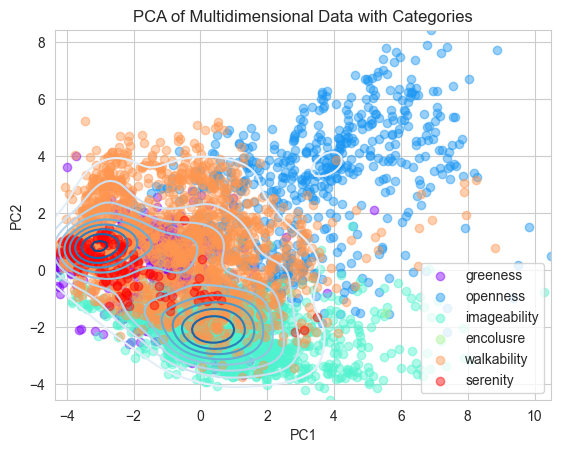

In [161]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

# Generate a color map based on categories
unique_categories = np.unique(categories)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_categories)))

# PCA transformation
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data)

# Scatter plot with color coding
for i, category in enumerate(unique_categories):
    plt.scatter(pca_result[categories == category, 0], pca_result[categories == category, 1], 
                color=colors[i], label=f'{category_names[category]}', alpha=.45)

# plt.hexbin(pca_result[:, 0], pca_result[:, 1], gridsize=30, cmap='Blues', alpha=0.5)
x, y = pca_result[:, 0], pca_result[:, 1]
k = kde.gaussian_kde([x, y])
xi, yi = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
plt.contour(xi, yi, zi.reshape(xi.shape), levels=10, cmap="Blues")

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.title('PCA of Multidimensional Data with Categories')
plt.show()

/var/folders/sq/rfgj79b152v5pdzf5bggycdh0000gn/T/ipykernel_22038/1086885659.py:21: DeprecationWarning: Please import `gaussian_kde` from the `scipy.stats` namespace; the `scipy.stats.kde` namespace is deprecated and will be removed in SciPy 2.0.0.
  k = kde.gaussian_kde([x, y])


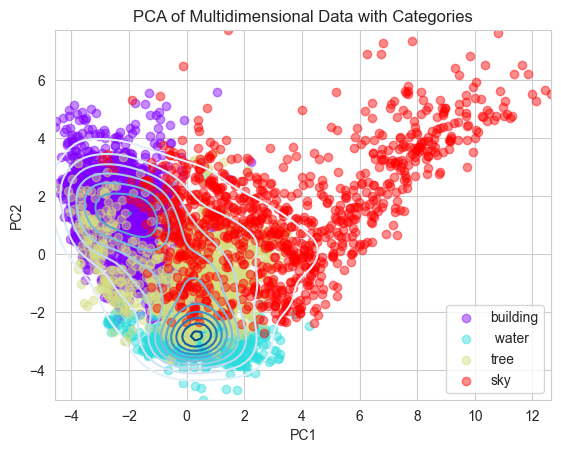

In [84]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

# Generate a color map based on categories
unique_categories = np.unique(categories)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_categories)))

# PCA transformation
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data)

# Scatter plot with color coding
for i, category in enumerate(unique_categories):
    plt.scatter(pca_result[categories == category, 0], pca_result[categories == category, 1], 
                color=colors[i], label=f'{category_names[category]}', alpha=.45)

# plt.hexbin(pca_result[:, 0], pca_result[:, 1], gridsize=30, cmap='Blues', alpha=0.5)
x, y = pca_result[:, 0], pca_result[:, 1]
k = kde.gaussian_kde([x, y])
xi, yi = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
plt.contour(xi, yi, zi.reshape(xi.shape), levels=10, cmap="Blues")

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.title('PCA of Multidimensional Data with Categories')
plt.show()

In [100]:
data           = nerf_latent_features
categories     = pr_colors
category_names = ['building', ' water', 'tree', 'sky']#[' building' ' water' ' road ' ' sidewalk' ' surface' ' tree' ' sky']


projection_df = pd.DataFrame({"x":pca_result[:,0]})


projection_df["coords"] = projection_df.apply(lambda x: pca_result[x.name], axis=1)
projection_df["color"]  = projection_df.apply(lambda x: nerf_predictions[x.name]/2+.5, axis=1)

projection_df.drop(["x"], axis=1).to_json("../legacy_charts_vis_generator/scatter.json", indent=4, orient="records")

/var/folders/sq/rfgj79b152v5pdzf5bggycdh0000gn/T/ipykernel_22038/1086885659.py:21: DeprecationWarning: Please import `gaussian_kde` from the `scipy.stats` namespace; the `scipy.stats.kde` namespace is deprecated and will be removed in SciPy 2.0.0.
  k = kde.gaussian_kde([x, y])


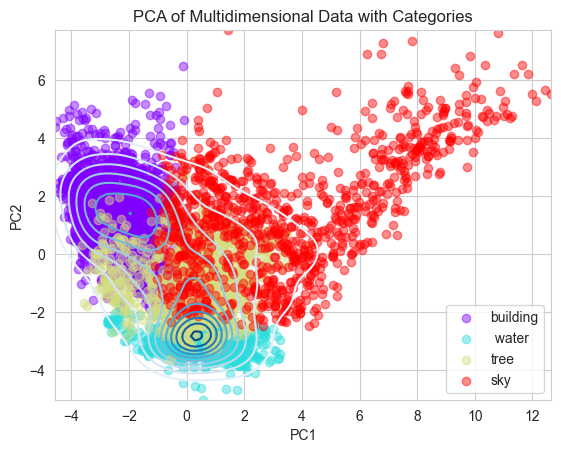

In [101]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

# Generate a color map based on categories
unique_categories = np.unique(categories)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_categories)))

# PCA transformation
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data)

# Scatter plot with color coding
for i, category in enumerate(unique_categories):
    plt.scatter(pca_result[categories == category, 0], pca_result[categories == category, 1], 
                color=colors[i], label=f'{category_names[category]}', alpha=.45)

# plt.hexbin(pca_result[:, 0], pca_result[:, 1], gridsize=30, cmap='Blues', alpha=0.5)
x, y = pca_result[:, 0], pca_result[:, 1]
k = kde.gaussian_kde([x, y])
xi, yi = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
plt.contour(xi, yi, zi.reshape(xi.shape), levels=10, cmap="Blues")

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.title('PCA of Multidimensional Data with Categories')
plt.show()

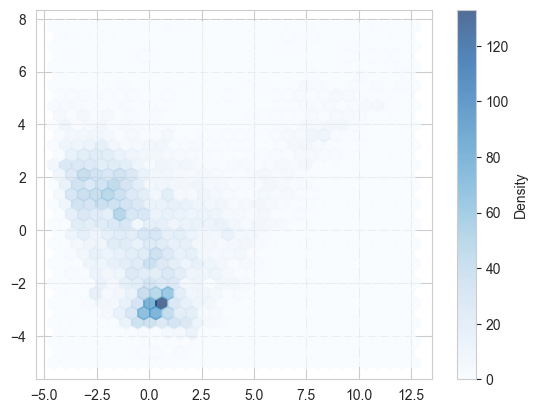

In [76]:
plt.hexbin(pca_result[:, 0], pca_result[:, 1], gridsize=30, cmap='Blues', alpha=0.7)
plt.colorbar(label='Density')
plt.show()

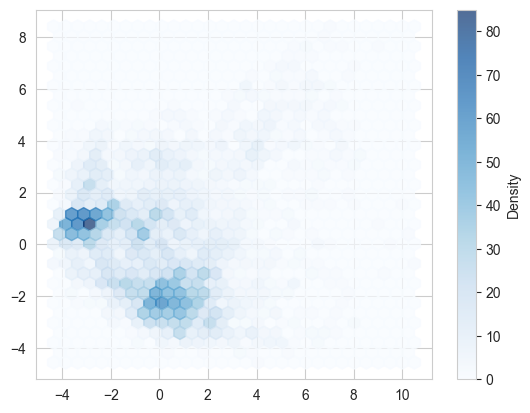

In [162]:
plt.hexbin(pca_result[:, 0], pca_result[:, 1], gridsize=30, cmap='Blues', alpha=0.7)
plt.colorbar(label='Density')
plt.show()

/var/folders/sq/rfgj79b152v5pdzf5bggycdh0000gn/T/ipykernel_22038/1965208672.py:5: DeprecationWarning: Please import `gaussian_kde` from the `scipy.stats` namespace; the `scipy.stats.kde` namespace is deprecated and will be removed in SciPy 2.0.0.
  k = kde.gaussian_kde([x, y])


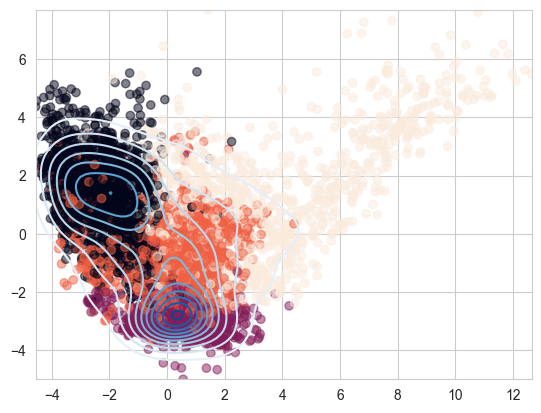

In [82]:
from scipy.stats import kde

# Example with PCA result
x, y = pca_result[:, 0], pca_result[:, 1]
k = kde.gaussian_kde([x, y])
xi, yi = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

plt.contour(xi, yi, zi.reshape(xi.shape), levels=10, cmap="Blues")
plt.scatter(x, y, c=categories, alpha=0.5)
plt.show()

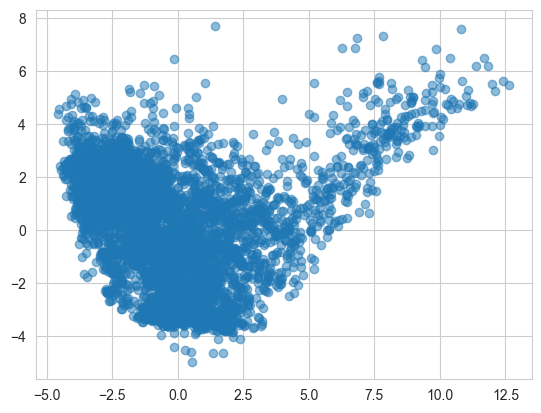

In [75]:
jitter = 0.01
jittered_data = pca_result + np.random.normal(0, jitter, pca_result.shape)

plt.scatter(jittered_data[:, 0], jittered_data[:, 1], alpha=0.5)

# 2. TSNE

/opt/homebrew/Caskroom/miniforge/base/envs/visibility_encoder/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


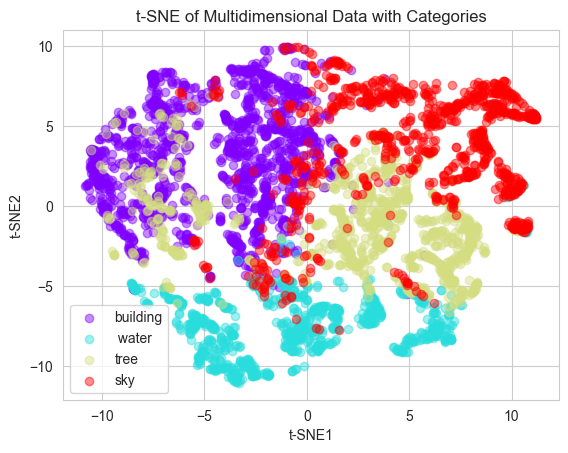

In [87]:
from sklearn.manifold import TSNE

# t-SNE transformation
tsne = TSNE(init="pca", learning_rate='auto', n_components=2, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(data)

# Scatter plot with color coding
for i, category in enumerate(unique_categories):
    plt.scatter(tsne_result[categories == category, 0], tsne_result[categories == category, 1], 
                color=colors[i], label=f'{category_names[category]}', alpha=.45)

    
# x, y = tsne_result[:, 0], tsne_result[:, 1]
# k = kde.gaussian_kde([x, y])
# xi, yi = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
# zi = k(np.vstack([xi.flatten(), yi.flatten()]))
# plt.contour(xi, yi, zi.reshape(xi.shape), levels=10, cmap="Blues")    
    

plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.legend()
plt.title('t-SNE of Multidimensional Data with Categories')
plt.show()

/opt/homebrew/Caskroom/miniforge/base/envs/visibility_encoder/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


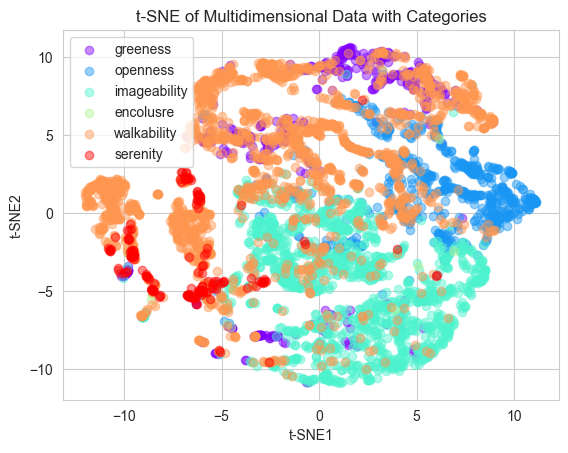

In [163]:
from sklearn.manifold import TSNE

# t-SNE transformation
tsne = TSNE(init="pca", learning_rate='auto', n_components=2, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(data)

# Scatter plot with color coding
for i, category in enumerate(unique_categories):
    plt.scatter(tsne_result[categories == category, 0], tsne_result[categories == category, 1], 
                color=colors[i], label=f'{category_names[category]}', alpha=.45)

    
# x, y = tsne_result[:, 0], tsne_result[:, 1]
# k = kde.gaussian_kde([x, y])
# xi, yi = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
# zi = k(np.vstack([xi.flatten(), yi.flatten()]))
# plt.contour(xi, yi, zi.reshape(xi.shape), levels=10, cmap="Blues")    
    

plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.legend()
plt.title('t-SNE of Multidimensional Data with Categories')
plt.show()

In [140]:
data   = nerf_latent_features
categories     = pr_colors
category_names = ['building', ' water', 'tree', 'sky']#[' building' ' water' ' road ' ' sidewalk' ' surface' ' tree' ' sky']


/opt/homebrew/Caskroom/miniforge/base/envs/visibility_encoder/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


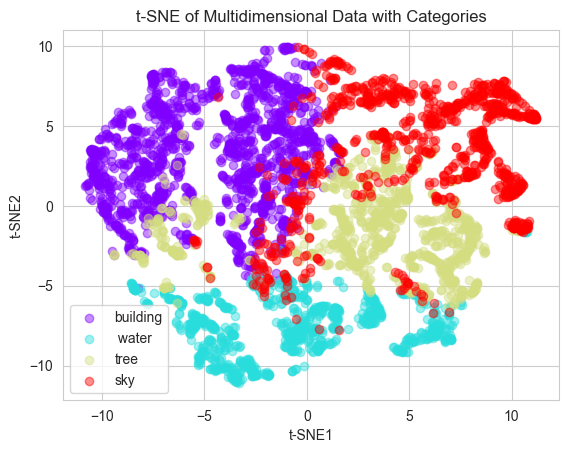

In [141]:
from sklearn.manifold import TSNE

# t-SNE transformation
tsne = TSNE(init="pca", learning_rate='auto', n_components=2, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(data)

# Scatter plot with color coding
for i, category in enumerate(unique_categories):
    plt.scatter(tsne_result[categories == category, 0], tsne_result[categories == category, 1], 
                color=colors[i], label=f'{category_names[category]}', alpha=.45)

    
# x, y = tsne_result[:, 0], tsne_result[:, 1]
# k = kde.gaussian_kde([x, y])
# xi, yi = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
# zi = k(np.vstack([xi.flatten(), yi.flatten()]))
# plt.contour(xi, yi, zi.reshape(xi.shape), levels=10, cmap="Blues")    
    

plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.legend()
plt.title('t-SNE of Multidimensional Data with Categories')
plt.show()

In [142]:
projection_df = pd.DataFrame({"x":tsne_result[:,0]})


projection_df["coords"] = projection_df.apply(lambda x: tsne_result[x.name], axis=1)
projection_df["color"]  = projection_df.apply(lambda x: nerf_predictions[x.name]/2+.5, axis=1)

projection_df.drop(["x"], axis=1).to_json("../legacy_charts_vis_generator/scatter_tsne.json", indent=4, orient="records")

# 3. UMAP

In [52]:
# !pip install umap-learn

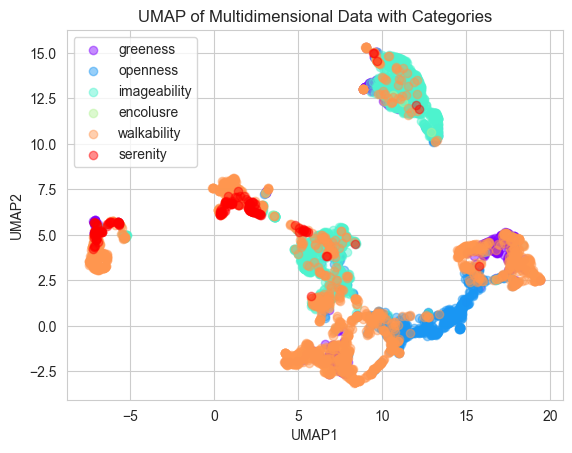

In [164]:
import umap
# UMAP transformation
umap_model = umap.UMAP(n_components=2)
umap_result = umap_model.fit_transform(data)

# Scatter plot with color coding
for i, category in enumerate(unique_categories):
    plt.scatter(umap_result[categories == category, 0], umap_result[categories == category, 1], 
                color=colors[i], label=f'{category_names[category]}', alpha=.45)

# x, y = umap_result[:, 0], umap_result[:, 1]
# k = kde.gaussian_kde([x, y])
# xi, yi = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
# zi = k(np.vstack([xi.flatten(), yi.flatten()]))
# plt.contour(xi, yi, zi.reshape(xi.shape), levels=10, cmap="Blues")      
    
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend()
plt.title('UMAP of Multidimensional Data with Categories')
plt.show()

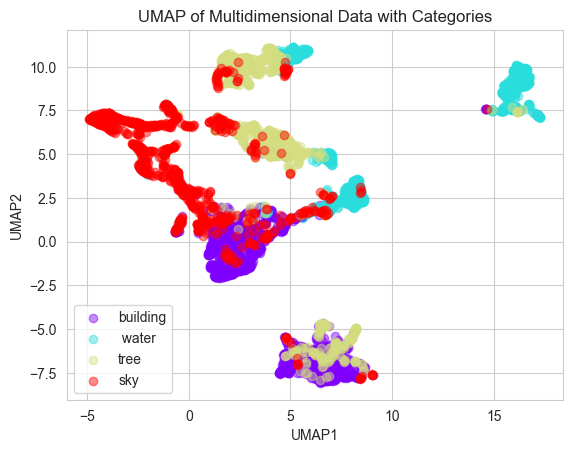

In [89]:
import umap
# UMAP transformation
umap_model = umap.UMAP(n_components=2)
umap_result = umap_model.fit_transform(data)

# Scatter plot with color coding
for i, category in enumerate(unique_categories):
    plt.scatter(umap_result[categories == category, 0], umap_result[categories == category, 1], 
                color=colors[i], label=f'{category_names[category]}', alpha=.45)

# x, y = umap_result[:, 0], umap_result[:, 1]
# k = kde.gaussian_kde([x, y])
# xi, yi = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
# zi = k(np.vstack([xi.flatten(), yi.flatten()]))
# plt.contour(xi, yi, zi.reshape(xi.shape), levels=10, cmap="Blues")      
    
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend()
plt.title('UMAP of Multidimensional Data with Categories')
plt.show()

In [143]:
data   = nerf_latent_features
categories     = pr_colors
category_names = ['building', ' water', 'tree', 'sky']#[' building' ' water' ' road ' ' sidewalk' ' surface' ' tree' ' sky']


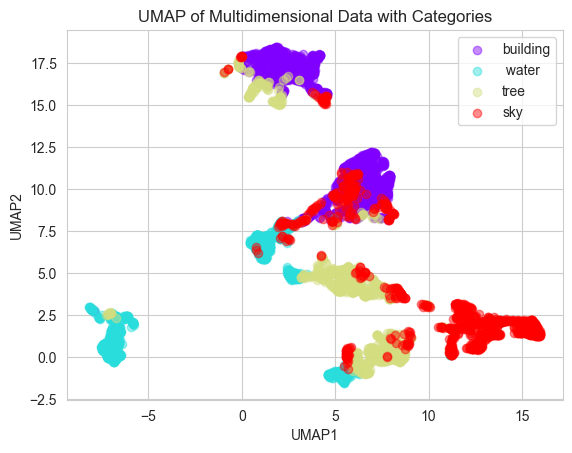

In [144]:
import umap
# UMAP transformation
umap_model = umap.UMAP(n_components=2)
umap_result = umap_model.fit_transform(data)

# Scatter plot with color coding
for i, category in enumerate(unique_categories):
    plt.scatter(umap_result[categories == category, 0], umap_result[categories == category, 1], 
                color=colors[i], label=f'{category_names[category]}', alpha=.45)

# x, y = umap_result[:, 0], umap_result[:, 1]
# k = kde.gaussian_kde([x, y])
# xi, yi = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
# zi = k(np.vstack([xi.flatten(), yi.flatten()]))
# plt.contour(xi, yi, zi.reshape(xi.shape), levels=10, cmap="Blues")      
    
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend()
plt.title('UMAP of Multidimensional Data with Categories')
plt.show()

In [145]:
projection_df = pd.DataFrame({"x":umap_result[:,0]})


projection_df["coords"] = projection_df.apply(lambda x: umap_result[x.name], axis=1)
projection_df["color"]  = projection_df.apply(lambda x: nerf_predictions[x.name]/2+.5, axis=1)

projection_df.drop(["x"], axis=1).to_json("../legacy_charts_vis_generator/scatter_umap.json", indent=4, orient="records")

# MiniSom

In [53]:
# !pip install MiniSom

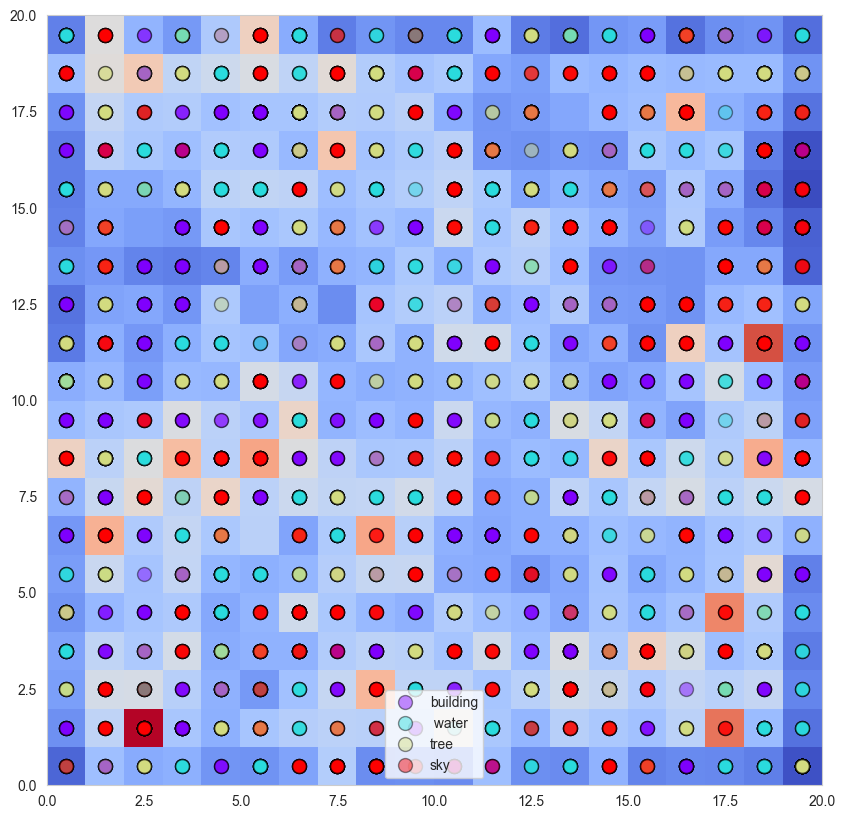

In [68]:
from minisom import MiniSom

# SOM initialization and training
som = MiniSom(x=20, y=20, input_len=data.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(data)
som.train_random(data, 100)

plt.figure(figsize=(10, 10))
plt.pcolor(som.distance_map().T, cmap='coolwarm')  # Background

# Scatter plot with color coding
for i, category in enumerate(unique_categories):
    for j, x in enumerate(data[categories == category]):
        w = som.winner(x)
        plt.plot(w[0] + 0.5, w[1] + 0.5, 'o', alpha=.45, markerfacecolor=colors[i], markeredgecolor='k', markersize=10, label=f'{category_names[category]}' if j == 0 else "")

plt.legend()
plt.show()

# Other tries, MDS (looks similar to PCA) and Drafts

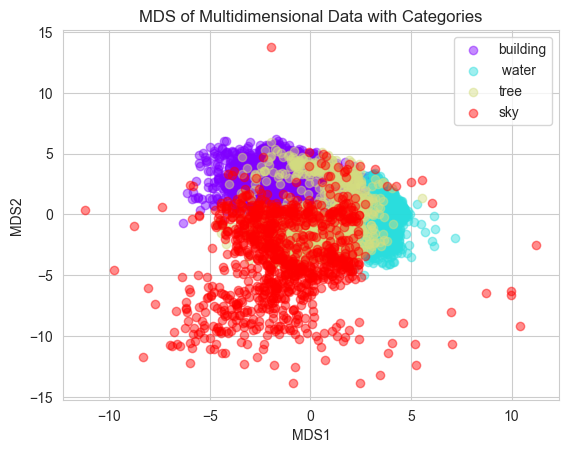

In [72]:
from sklearn.manifold import MDS

# MDS transformation
mds = MDS(n_components=2, n_init=2, max_iter=100, verbose=0)
mds_result = mds.fit_transform(data)

# Scatter plot with color coding
for i, category in enumerate(unique_categories):
    plt.scatter(mds_result[categories == category, 0], mds_result[categories == category, 1], 
                color=colors[i], label=f'{category_names[category]}', alpha=.45)

plt.xlabel('MDS1')
plt.ylabel('MDS2')
plt.legend()
plt.title('MDS of Multidimensional Data with Categories')
plt.show()

it: 0, stress 340194043.72822624
it: 1, stress 93793192.02634367
it: 2, stress 77322071.09101409
it: 3, stress 71531927.3105485
it: 4, stress 68448607.8008158
it: 5, stress 66744023.91598787
it: 6, stress 65941053.642502576
it: 7, stress 65412256.67430255
it: 8, stress 65026337.41399789
it: 9, stress 64722592.32162339
it: 10, stress 64471194.702613354
it: 11, stress 64250869.79554803
it: 12, stress 64041336.85288259
it: 13, stress 63823883.69304723
it: 14, stress 63582161.7302003
it: 15, stress 63300640.497274354
it: 16, stress 62962414.2790335
it: 17, stress 62548203.417261474
it: 18, stress 62036254.1569847
it: 19, stress 61401321.748818584
it: 20, stress 60614267.70613014
it: 21, stress 59646334.84593417
it: 22, stress 58471806.695036076
it: 23, stress 57069860.08868488
it: 24, stress 55439482.695697084
it: 25, stress 53603756.60255382
it: 26, stress 51609255.06706686
it: 27, stress 49521279.06652977
it: 28, stress 47409388.88760643
it: 29, stress 45344286.14002211
it: 30, stress 43

it: 242, stress 15736184.183766985
it: 243, stress 15571651.187110307
it: 244, stress 15423062.19320778
it: 245, stress 15289753.672162468
it: 246, stress 15169704.191103129
it: 247, stress 15059118.17534067
it: 248, stress 14954070.74333891
it: 249, stress 14852979.585732244
it: 250, stress 14756414.490410095
it: 251, stress 14664355.151778817
it: 252, stress 14575224.289419927
it: 253, stress 14487003.753265377
it: 254, stress 14398212.47119827
it: 255, stress 14306554.230127307
it: 256, stress 14211638.47457805
it: 257, stress 14116791.396935424
it: 258, stress 14027515.062992949
it: 259, stress 13945953.432766076
it: 260, stress 13869390.092939543
it: 261, stress 13795104.964619484
it: 262, stress 13722440.502703
it: 263, stress 13651628.772969794
it: 264, stress 13583615.296349518
it: 265, stress 13520222.82646047
it: 266, stress 13460299.840611866
it: 267, stress 13400971.135577863
it: 268, stress 13339501.430576803
it: 269, stress 13274815.471755987
it: 270, stress 13208943.3049

it: 182, stress 11780876.731421093
it: 183, stress 11772434.177326553
it: 184, stress 11768182.812106669
it: 185, stress 11766318.174218908
it: 186, stress 11765207.537142709
it: 187, stress 11764321.955146601
it: 188, stress 11763565.392854871
it: 189, stress 11762905.961788708
it: 190, stress 11762330.779207379
it: 191, stress 11761822.914571546
it: 192, stress 11761367.660648389
it: 193, stress 11760961.12032955
it: 194, stress 11760601.764536327
it: 195, stress 11760283.164277242
it: 196, stress 11759999.607766805
it: 197, stress 11759746.385665042
it: 198, stress 11759519.543414367
it: 199, stress 11759315.255765136
it: 200, stress 11759131.043901805
it: 201, stress 11758964.788042104
it: 202, stress 11758814.418395549
it: 203, stress 11758678.077892303
it: 204, stress 11758554.054500425
it: 205, stress 11758440.762491584
it: 206, stress 11758336.940464327
it: 207, stress 11758241.033549681
it: 208, stress 11758152.043467958
it: 209, stress 11758069.993821505
it: 210, stress 11757

it: 137, stress 25954494.77965745
it: 138, stress 25895815.89090406
it: 139, stress 25833938.28377164
it: 140, stress 25768975.08867951
it: 141, stress 25700806.951259386
it: 142, stress 25629197.517987538
it: 143, stress 25554027.4619027
it: 144, stress 25474915.2637312
it: 145, stress 25391485.05280261
it: 146, stress 25303169.743751083
it: 147, stress 25209841.14216857
it: 148, stress 25111727.80038316
it: 149, stress 25008674.550393056
it: 150, stress 24900365.733892813
it: 151, stress 24786743.16753261
it: 152, stress 24668000.064648174
it: 153, stress 24544248.22596515
it: 154, stress 24415211.773457613
it: 155, stress 24280257.64728957
it: 156, stress 24138776.37740746
it: 157, stress 23990221.79291847
it: 158, stress 23834141.475105993
it: 159, stress 23669569.10955138
it: 160, stress 23496226.000995446
it: 161, stress 23313862.51092625
it: 162, stress 23122398.932814475
it: 163, stress 22921284.19670712
it: 164, stress 22710513.22241692
it: 165, stress 22490984.351796858
it: 1

it: 77, stress 26942419.156349074
it: 78, stress 26914197.134418823
it: 79, stress 26886715.522222195
it: 80, stress 26859857.614279542
it: 81, stress 26833497.76413366
it: 82, stress 26807531.292699754
it: 83, stress 26781860.94938009
it: 84, stress 26756404.77892127
it: 85, stress 26731066.763656393
it: 86, stress 26705748.901198864
it: 87, stress 26680360.713330533
it: 88, stress 26654804.63854464
it: 89, stress 26628980.565183695
it: 90, stress 26602801.18915154
it: 91, stress 26576159.619064093
it: 92, stress 26548937.55568349
it: 93, stress 26521034.18054671
it: 94, stress 26492342.583042104
it: 95, stress 26462730.24102127
it: 96, stress 26432040.206957266
it: 97, stress 26400132.37412704
it: 98, stress 26366842.415860694
it: 99, stress 26332000.387482915
it: 100, stress 26295429.77550482
it: 101, stress 26256957.47534653
it: 102, stress 26216352.055978563
it: 103, stress 26173356.8019353
it: 104, stress 26127663.44493797
it: 105, stress 26078997.978991512
it: 106, stress 260270

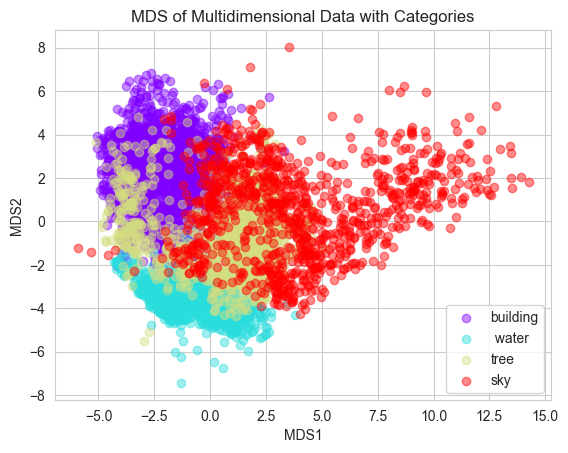

In [70]:
from sklearn.manifold import MDS

# MDS transformation
mds = MDS(n_components=2, verbose=2)
mds_result = mds.fit_transform(data)

# Scatter plot with color coding
for i, category in enumerate(unique_categories):
    plt.scatter(mds_result[categories == category, 0], mds_result[categories == category, 1], 
                color=colors[i], label=f'{category_names[category]}', alpha=.45)

plt.xlabel('MDS1')
plt.ylabel('MDS2')
plt.legend()
plt.title('MDS of Multidimensional Data with Categories')
plt.show()

In [ ]:
import seaborn as sns
import pandas as pd

# Assuming 'categories' is a list of categories corresponding to rows in 'data'
df = pd.DataFrame(data)
df['label'] = categories  # Add category as a new column
df['Category'] = df['label'].apply(lambda l: categories[l])  # Add category as a new column

# Pairplot with category coloring
sns.pairplot(df.sample(10), hue='Category')
plt.show()